# Unsupervised Machine Learning - Moosic Project

- Using a 5000 songs dataset with audio features from spotify API
- Goal is identifying clusters in the dataset of auditive/musically similar songs
- Part of WBS coding school bootcamp

# Import Libraries

In [2343]:
import random
# ---
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
# ---
import warnings
warnings.filterwarnings('ignore')
# ---
import vertexai
from pathlib import Path
from vertexai.generative_models import GenerativeModel, ChatSession
# ---
import time
import re
# -- Data
import numpy as np
import pandas as pd
# --- ML
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans
# Scaler/Transformers for KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
# --- Plot
import matplotlib.pyplot as plt
import seaborn as sns
# --- 
from IPython.display import display, HTML, clear_output
# ---
pd.set_option('display.max_colwidth', None) # Don't cut off columns (=max width per column)

# Make HTML table

To provide clickable links of spotify-songs and aid in quality assessement.

In [1369]:
def makehtmltable(df):

    html_table = """
        <table>
            <tr>
                <th></th>
                <th>Song Name</th>
                <th>Artist</th>
                <th>HTML</th>
                <th>Cluster</th>
            </tr>
            """

    for i in range(0,df.shape[0]):
        html_table += f"""
            <tr>
                <td>
                    {i}
                </td>
                <td>
                    {df.iloc[i,0]}
                </td>
                <td>
                    {df.iloc[i,1]}
                </td>
                <td>
                    <a href={df.iloc[i,2]}>[Link to Song]
                    </a>
                </td>
                <td>
                    {df.iloc[i,3]}
                </td>
            </tr>
        """

    html_table += "</table>"

    display(HTML(html_table))

# Import & Clean Data

## Dataset A

This was just a little test-data set to get into the process.

In [555]:
folder = "data/"

songs = pd.read_csv(folder + '2_spotify_10_songs.csv')

# Delete empty spaces from column names
for i,cname in enumerate(songs.columns):
    cname = cname.replace(' ','')
    songs.columns.values[i] = cname

# Delete empty spaces from song name column
songs['song_name'] = songs['song_name'].str.strip()
# Delete empty spaces from artist name column
songs['artist'] = songs['artist'].str.strip()
    
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         10 non-null     object 
 1   artist            10 non-null     object 
 2   danceability      10 non-null     float64
 3   energy            10 non-null     float64
 4   key               10 non-null     int64  
 5   loudness          10 non-null     float64
 6   mode              10 non-null     int64  
 7   speechiness       10 non-null     float64
 8   acousticness      10 non-null     float64
 9   instrumentalness  10 non-null     float64
 10  liveness          10 non-null     float64
 11  valence           10 non-null     float64
 12  tempo             10 non-null     float64
 13  duration_ms       10 non-null     int64  
 14  time_signature    10 non-null     int64  
 15  id                10 non-null     object 
 16  html              10 non-null     object 
dtype

### Normalize/Scale data (manual approach)

This is a primitive manual approach to avoid skewing from loudness and tempo values.

In [9]:
songs_norm = songs.copy()

# ID and HTML are not needed for analysis
songs_norm = songs_norm.drop(columns=['id','html'])

# Loudness is typically between 0 and -60 (source: LMS)
songs_norm['loudness'] = songs_norm['loudness']/60

# Speedcore is defined as songs above 300 BPM (source: Wikipedia/Speedcore)
songs_norm['tempo'] = songs_norm['tempo']/400

songs.sample(5)

,song_name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,html
5,Sultans Of Swing,Dire Straits,0.733,0.794,5,-10.023,1,0.0307,0.06140,0.03670,0.330,0.9310,148.174,348624,4,6cr6UDpkjEaMQ80OjWqEBQ,https://open.spotify.com/track/6cr6UDpkjEaMQ80OjWqEBQ
2,Águas De Março,Antônio Carlos Jobim,0.642,0.339,3,-15.503,1,0.1400,0.85400,0.00000,0.105,0.4910,143.418,212400,4,1y7OxO5i6sfrHXAmUM77YG,https://open.spotify.com/track/1y7OxO5i6sfrHXAmUM77YG
3,The Girl From Ipanema,Stan Getz,0.641,0.140,8,-16.790,1,0.0390,0.86700,0.00166,0.105,0.3880,129.318,317987,4,3898C4AbdbptwYet6547e5,https://open.spotify.com/track/3898C4AbdbptwYet6547e5
4,"Paint It, Black",The Rolling Stones,0.464,0.795,1,-9.267,1,0.0926,0.04930,0.00244,0.399,0.6120,158.691,202267,4,63T7DJ1AFDD6Bn8VzG6JE8,https://open.spotify.com/track/63T7DJ1AFDD6Bn8VzG6JE8
6,Space Raiders - Charlotte de Witte Remix,Eats Everything,0.749,0.731,4,-10.865,1,0.1080,0.00314,0.86700,0.111,0.0598,131.997,438720,4,4F8OK7mNa51mKqgHqWQiYm,https://open.spotify.com/track/4F8OK7mNa51mKqgHqWQiYm


## Dataset B

This is the actual dataset for this project, containing ca. 5235 songs.

In [1371]:
folder = "data/"

# Import data and drop "unnamed" column
songs2 = pd.read_csv(folder + '3_spotify_5000_songs.csv')

# Delete empty spaces from column names
for i,cname in enumerate(songs2.columns):
    cname = cname.strip()
    songs2.columns.values[i] = cname

# Delete empty spaces from song name column
songs2['name'] = songs2['name'].str.strip()
# Delete empty spaces from artist name column
songs2['artist'] = songs2['artist'].str.strip()

# Drop unnecessary columns
songs2 = songs2.drop(columns=['Unnamed: 0','type'])

# Rename name column for consistency
songs2 = songs2.rename(columns={'name':'song_name'})

songs2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5235 entries, 0 to 5234
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         5235 non-null   object 
 1   artist            5235 non-null   object 
 2   danceability      5235 non-null   float64
 3   energy            5235 non-null   float64
 4   key               5235 non-null   int64  
 5   loudness          5235 non-null   float64
 6   mode              5235 non-null   int64  
 7   speechiness       5235 non-null   float64
 8   acousticness      5235 non-null   float64
 9   instrumentalness  5235 non-null   float64
 10  liveness          5235 non-null   float64
 11  valence           5235 non-null   float64
 12  tempo             5235 non-null   float64
 13  duration_ms       5235 non-null   int64  
 14  time_signature    5235 non-null   int64  
 15  id                5235 non-null   object 
 16  html              5235 non-null   object 


# Data analysis A

This is the spotify playlist of the 10 song test dataset:<br>
https://open.spotify.com/playlist/2WyxU9mT4S1XhBnQva7Jkt?si=2ef3cbca30aa4661

## Attributes visualization

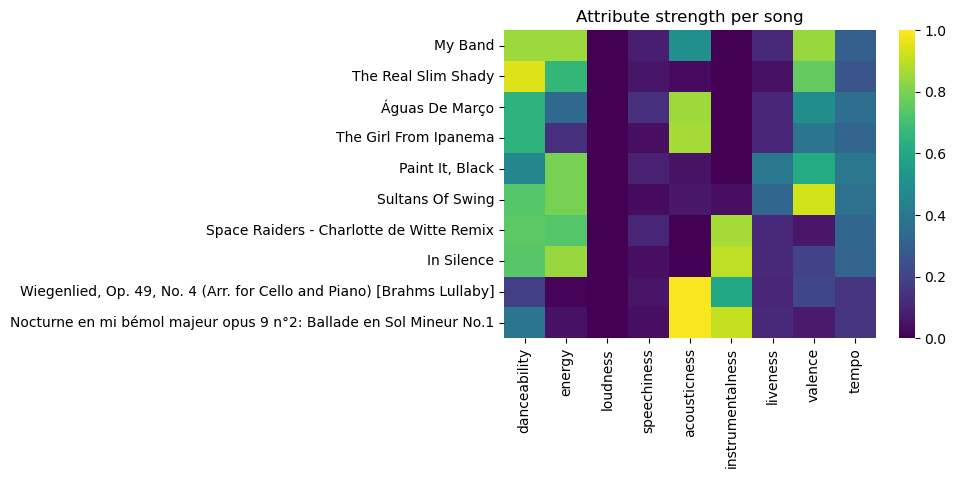

In [14]:
df = songs_norm.loc[:,['song_name',
            'danceability',
            'energy',
            'loudness',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'tempo']]

df = df.set_index('song_name')


fig, ax = plt.subplots(figsize=(6,4))

ax = sns.heatmap(
    df,
    vmin=0,
    vmax=1,
    cmap='viridis',
    );
ax.set_ylabel('');
ax.set_title('Attribute strength per song');

## Attributes distance (manual)
This approach doesn't work (except for the 2 classic tunes)

In [16]:
# Get only "musical" numerical values from songs

# --> Trying to use song_norm (with veeery basic normalization) doesn't yield good results
# df = songs_norm.drop(columns=['song_name','artist','duration_ms'])

# --> Using only 0-1 values gives a plausible result!
df = songs_norm.drop(columns=['song_name','artist','duration_ms','loudness','time_signature','tempo','key'])

# Make numpy array from it
A = df.to_numpy()

# Initialize array to store "distance" values
D = np.zeros([df.shape[0],df.shape[0]])
D2 = np.copy(D)

# Go through each row (= song)
for i in range(A.shape[0]):
    # Go through each row again (= song to compare)
    for k in range(A.shape[0]):
        # Subtract vector with musical attribs. of song B from song A
        # Then get norm of resulting difference-vector
        # Store norm in D
        D[i,k] = np.linalg.norm(A[i,:] - A[k,:])
    # Store distances in D2
    D2[i,:] = D[i,:]
    # Take current row of results (=norms), sort ascending and return indices
    # (Will always have current row in first place, because distance to self is 0)
    D[i,:] = np.argsort(D[i,:])
    

# Closest "partner" for each song is stored in second column of D
# (first column is self)
nearest = D[:,1]

# Retrieve song-names from index
nearest_songs = songs['song_name'].iloc[nearest.astype(int)]

# Compare reference and calculated result
res_by_norm = pd.DataFrame({'reference':songs_norm['song_name'],'closest_by_norm':list(nearest_songs)})

res_by_norm

,reference,closest_by_norm
0,My Band,The Real Slim Shady
1,The Real Slim Shady,My Band
2,Águas De Março,The Girl From Ipanema
3,The Girl From Ipanema,Águas De Março
4,"Paint It, Black",Sultans Of Swing
5,Sultans Of Swing,"Paint It, Black"
6,Space Raiders - Charlotte de Witte Remix,In Silence
7,In Silence,Space Raiders - Charlotte de Witte Remix
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]",Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1
9,Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]"


## Distances using SciKit-Learn

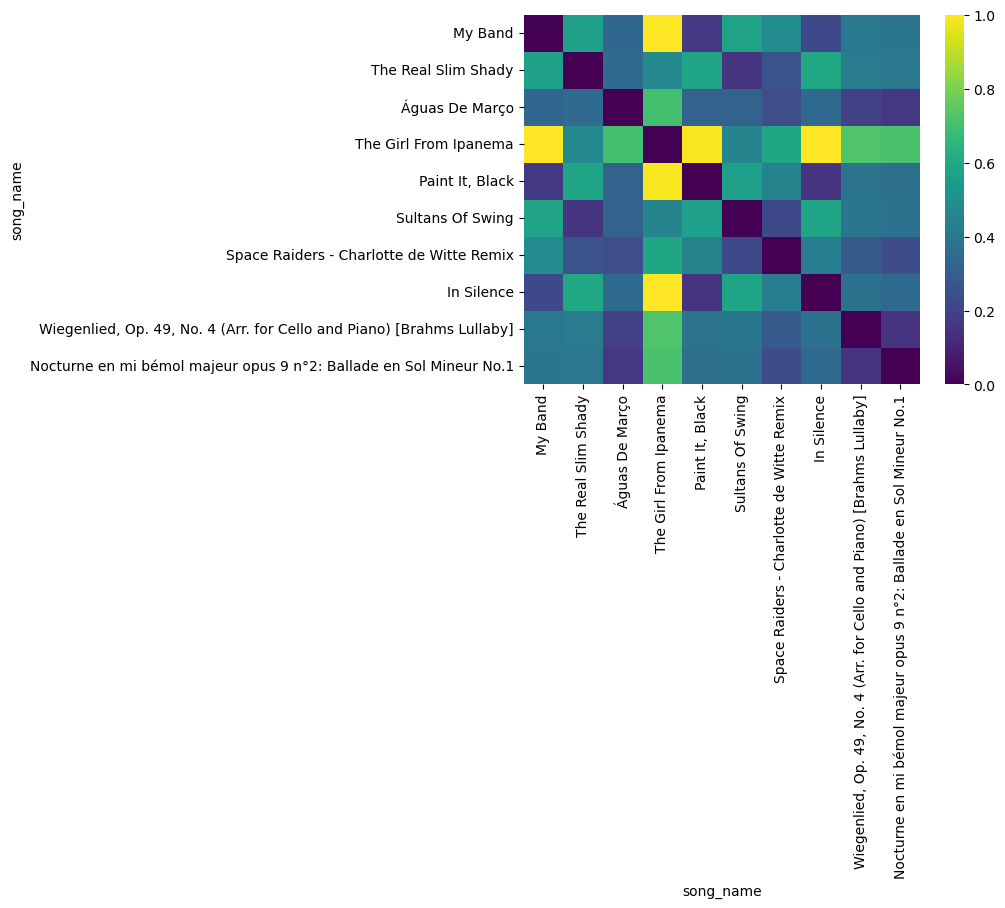

In [18]:
# Get only "musical" numerical values from songs
df = songs_norm.drop(columns=['artist','duration_ms']).set_index('song_name')

D2 = pairwise_distances(df, metric='euclidean')

res_by_norm2 = pd.DataFrame(D2,index=df.index,columns=df.index)

ax = sns.heatmap(
    res_by_norm2/(D2.max()),
    vmin=0,
    vmax=1,
    cmap='viridis',
    );

## Distances using square distances between attributes per song
This approach also doesn't work

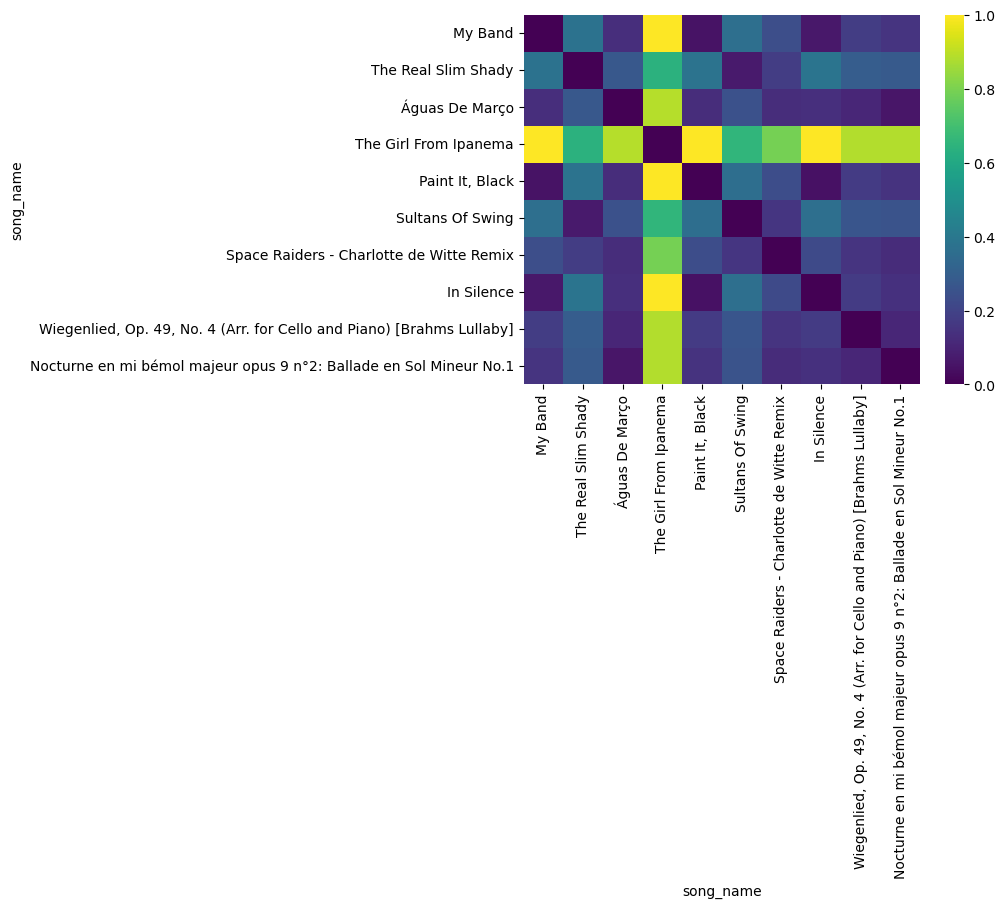

In [20]:
# Get only "musical" numerical values from songs
df = songs_norm.drop(columns=['song_name','artist','duration_ms'])

# Make numpy array from it
sr = df.shape[0]
sc = df.shape[1]
A = np.zeros([sr,sc**2])

# The idea:
# Take the differences between attributes per single song (loudness-dancebility,loudness-energy etc.)
# Squares these differences and store it in a matrix
for i in range(sr):
    for k in range(sc):
        for m in range(sc):
            A[i, (k*sc)+m] = (df.iloc[i,k]-df.iloc[i,m])**2


# Get pairwise distances of those differences
# To see which song has similar differences
D2 = pairwise_distances(A, metric='euclidean')

res_by_norm2 = pd.DataFrame(D2,index=songs_norm['song_name'],columns=songs_norm['song_name'])

ax = sns.heatmap(
    res_by_norm2/(D2.max()),
    vmin=0,
    vmax=1,
    cmap='viridis',
    );

## K-Means

### Basic clustering

Using yet unscaled data.

In [23]:
# Get only "musical" numerical values from songs
df = songs_norm.drop(columns=['song_name','artist','duration_ms'])

seed = 234
# Initialize model
my_kmeans = KMeans(n_clusters = 5, random_state = seed)

# Fit model to data
my_kmeans.fit(df)

# Get cluster output
table = my_kmeans.labels_

# Put clusters and song-names toghether in a DF
df = pd.DataFrame({'song_name':list(songs['song_name']),'cluster':list(table)})

# Output songs sorted by cluster
df.sort_values('cluster')


C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,song_name,cluster
2,Águas De Março,0
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]",0
9,Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1,0
1,The Real Slim Shady,1
5,Sultans Of Swing,1
0,My Band,2
4,"Paint It, Black",2
7,In Silence,2
3,The Girl From Ipanema,3
6,Space Raiders - Charlotte de Witte Remix,4


### Scaling

Scaling data before clustering is necessay to avoid skewing of the results due to relative differences in the feature values.

#### Min/Max Scaler

Scaling data to a 0...1 range.

In [26]:
df = songs.drop(columns=['song_name','artist','id','html','duration_ms'])

# Create a MinMaxScaler object
scaler = MinMaxScaler().set_output(transform="pandas")

seed = 12345
# Initialize model
my_kmeans = KMeans(n_clusters = 5,
                   random_state = seed)

# Fit model to data
my_kmeans.fit(scaler.fit_transform(df))
# Get cluster IDs
song_ind = my_kmeans.labels_
# Output results
pd.DataFrame({'song_name':songs['song_name'],'cluster':song_ind})

C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,song_name,cluster
0,My Band,0
1,The Real Slim Shady,0
2,Águas De Março,4
3,The Girl From Ipanema,4
4,"Paint It, Black",3
5,Sultans Of Swing,3
6,Space Raiders - Charlotte de Witte Remix,2
7,In Silence,2
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]",1
9,Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1,1


#### Standard Scaler

Standardize features by removing the mean and scaling to unit variance.

In [28]:
df = songs.drop(columns=['song_name','artist','id','html','duration_ms'])

# Create a StandardScaler object
scaler = StandardScaler().set_output(transform="pandas")

seed = 12345
# Initialize model
my_kmeans = KMeans(n_clusters = 5,
                   random_state = seed)

# Fit model to data
my_kmeans.fit(scaler.fit_transform(df))
# Get cluster IDs
song_ind = my_kmeans.labels_
# Output results
pd.DataFrame({'song_name':songs['song_name'],'cluster':song_ind})

C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,song_name,cluster
0,My Band,0
1,The Real Slim Shady,0
2,Águas De Março,4
3,The Girl From Ipanema,4
4,"Paint It, Black",3
5,Sultans Of Swing,3
6,Space Raiders - Charlotte de Witte Remix,2
7,In Silence,2
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]",1
9,Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1,1


#### Robust Scaler

Scale features using statistics that are robust to outliers.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [30]:
df = songs.drop(columns=['song_name','artist','id','html','duration_ms'])

# Create a RobustScaler object
scaler = RobustScaler().set_output(transform="pandas")

seed = 12345
# Initialize model
my_kmeans = KMeans(n_clusters = 5,
                   random_state = seed)

# Fit model to data
my_kmeans.fit(scaler.fit_transform(df))
# Get cluster IDs
song_ind = my_kmeans.labels_
# Output results
pd.DataFrame({'song_name':songs['song_name'],'cluster':song_ind})

C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,song_name,cluster
0,My Band,0
1,The Real Slim Shady,3
2,Águas De Março,0
3,The Girl From Ipanema,0
4,"Paint It, Black",2
5,Sultans Of Swing,1
6,Space Raiders - Charlotte de Witte Remix,0
7,In Silence,0
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]",4
9,Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1,4


#### Quantile Transformer

Transform features using quantiles information.

This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.

In [32]:
df = songs.drop(columns=['song_name','artist','id','html','duration_ms'])

# Create a QuantileTransformer object
scaler = QuantileTransformer(n_quantiles = df.shape[0]).set_output(transform="pandas")

seed = 12345
# Initialize model
my_kmeans = KMeans(n_clusters = 5,
                   random_state = seed)

# Fit model to data
my_kmeans.fit(scaler.fit_transform(df))
# Get cluster IDs
song_ind = my_kmeans.labels_
# Output results
pd.DataFrame({'song_name':songs['song_name'],'cluster':song_ind})

C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,song_name,cluster
0,My Band,3
1,The Real Slim Shady,3
2,Águas De Março,4
3,The Girl From Ipanema,4
4,"Paint It, Black",2
5,Sultans Of Swing,2
6,Space Raiders - Charlotte de Witte Remix,0
7,In Silence,0
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]",1
9,Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1,1


#### Power Transformer

Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

In [34]:
df = songs.drop(columns=['song_name','artist','id','html','duration_ms'])

# Create a PowerTransformer object
scaler = PowerTransformer().set_output(transform="pandas")

seed = 12345
# Initialize model
my_kmeans = KMeans(n_clusters = 5,
                   random_state = seed)

# Fit model to data
my_kmeans.fit(scaler.fit_transform(df))
# Get cluster IDs
song_ind = my_kmeans.labels_
# Output results
pd.DataFrame({'song_name':songs['song_name'],'cluster':song_ind})

C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,song_name,cluster
0,My Band,4
1,The Real Slim Shady,4
2,Águas De Março,1
3,The Girl From Ipanema,1
4,"Paint It, Black",2
5,Sultans Of Swing,2
6,Space Raiders - Charlotte de Witte Remix,0
7,In Silence,0
8,"Wiegenlied, Op. 49, No. 4 (Arr. for Cello and Piano) [Brahms Lullaby]",3
9,Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1,3


# Data analysis B

## KMeans + Standard Scaler

In [1373]:
# Prep dataframe
df = songs2.drop(columns=['song_name','artist','id','html','duration_ms'])

# Create a StandardScaler object
scaler = StandardScaler().set_output(transform="pandas")

# Initialize Model
nc = 8
my_kmeans = KMeans(n_clusters = nc)

# Fit model to scaled data
my_kmeans.fit(scaler.fit_transform(df))

# Get array of clusters
clusters = my_kmeans.labels_

# Clustererd DF
df2 = pd.DataFrame({'song_name':songs2['song_name'],'artist':songs2['artist'],'cluster':list(clusters)})

# Make new DF for cluster-overview
df3 = pd.DataFrame({'song_name':[],'artist':[],'cluster':[]})
for i in range(nc):
    A = df2[df2['cluster']==i].reset_index(drop=True)
    df3 = pd.concat([df3,A.sample(3)])

df3

,song_name,artist,cluster
41,For The Feel,Bleached,0.0
144,Bumpy Ride,Mohombi,0.0
480,Rock The House,Afrojack,0.0
556,Bags' Groove - Rudy Van Gelder 2001 - Remaster,Milt Jackson,1.0
416,"Die Zauberflöte, K.620 / Act 2: ""Der Hölle Rache kocht in meinem Herzen""",Wolfgang Amadeus Mozart,1.0
319,Fire and Rain,James Taylor,1.0
377,"Oh, Pretty Woman",Roy Orbison,2.0
903,Beam Me Up - Radio Edit,CAZZETTE,2.0
1182,Schwarz und Weiss - Radio Edit,Oliver Pocher,2.0
384,My Funny Valentine,Chet Baker,3.0


## KMeans + Standard Scaler - using predict

In [1537]:
# Prep dataframe
df = songs2.drop(columns=['song_name','artist','id','html','duration_ms'])

# Create a StandardScaler object
scaler = StandardScaler().set_output(transform="pandas")

# Initialize Model
nc = 22
my_kmeans = KMeans(n_clusters = nc)

# Fit model to scaled data
clusters = my_kmeans.fit_predict(scaler.fit_transform(df))

songs2_cluster = songs2
songs2_cluster['cluster'] = clusters

# Clustererd DF
df2 = pd.DataFrame({'song_name':songs2['song_name'],'artist':songs2['artist'],'html':songs2['html'],'cluster':list(clusters)})

# Make new DF for cluster-overview
df3 = pd.DataFrame({'song_name':[],'artist':[],'html':[],'cluster':[]})
for i in range(nc):
    A = df2[df2['cluster']==i].reset_index(drop=True)
    df3 = pd.concat([df3,A.sample(3)])

# Show results as HTML table with a few songs per cluster
makehtmltable(df3)

,Song Name,Artist,HTML,Cluster
0,No Destiny,Edge Of Sanity,[Link to Song],0.0
1,Electro-Convulsive Therapy,Cancer,[Link to Song],0.0
2,Mr. Brightside,The Killers,[Link to Song],0.0
3,Summer Of '69,Bryan Adams,[Link to Song],1.0
4,Ich bin ich (Wir sind wir),Rosenstolz,[Link to Song],1.0
5,Jumpin' Jack Flash,The Rolling Stones,[Link to Song],1.0
6,Algo Novo,Deolinda,[Link to Song],2.0
7,Blue Train - Remastered 2003,John Coltrane,[Link to Song],2.0
8,Chitlins Con Carne,Kenny Burrell,[Link to Song],2.0
9,Symphonia: Sum Fluxae Pretium Spei: 2. Adagio tenebroso,Elliott Carter,[Link to Song],3.0


## Grouping by Cluster

Plot distribution of auditive/musical features among cluster for comparison.

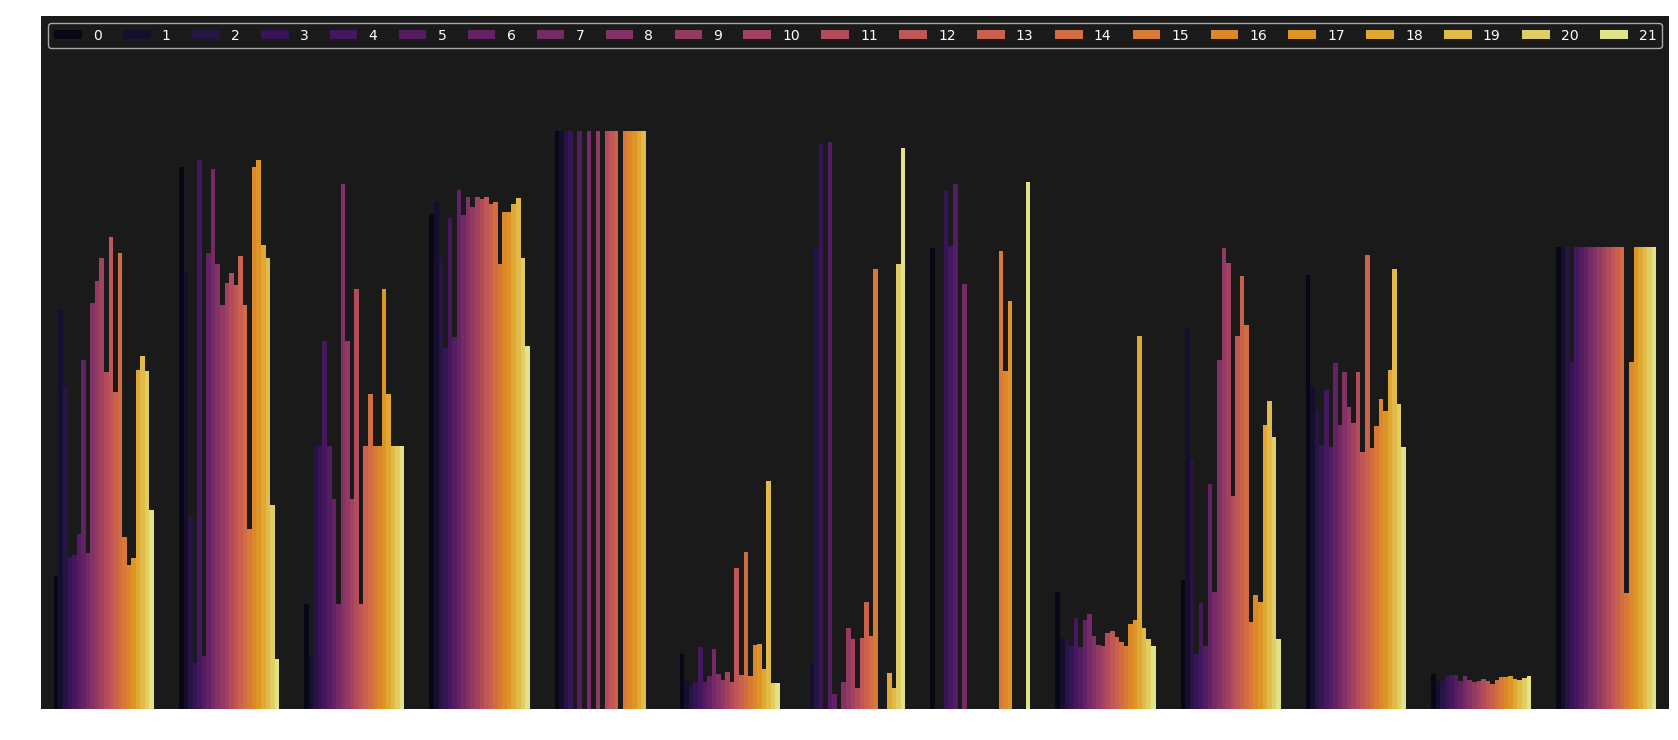

In [2763]:
df = songs2_cluster.set_index(['song_name','artist']).drop(columns=['id','html'])

# Doesn't work right now..?!
# print(df.groupby('cluster',as_index=False).mean())

minmax = MinMaxScaler(feature_range=(0,1))
df_scale = minmax.fit_transform(df)

df_scale = pd.DataFrame(df_scale, index=df.index, columns=df.columns)

df_scale['cluster'] = df['cluster']

df2 = df_scale.groupby('cluster',as_index=False).median().melt(id_vars='cluster',var_name='feature',value_name='value')

plt.figure(figsize=(21,9))

ax = sns.barplot(
    data = df2,
    y = 'value',
    hue = 'cluster',
    x = 'feature',
    palette='inferno'
)

legend = plt.legend(ncol=df2['cluster'].max()+1, mode='expand')
legend.get_frame().set_facecolor('none')
for text in legend.get_texts():
    text.set_color('white')

# ax.set_title('scaled features per cluster')
# ax.grid()
# ax.set_axisbelow(True)
ax.set_facecolor(0.1*np.ones([1,3]))
ax.set_ylim(0,1.2);
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(fontsize=12,color='White')
plt.yticks(fontsize=12,color='White')

# Remove frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)

# Save as PNG with Alpha
plt.savefig('test.png',transparent=True,dpi=300)

### Song durations

Plot overall song-duration of full dataset in minutes

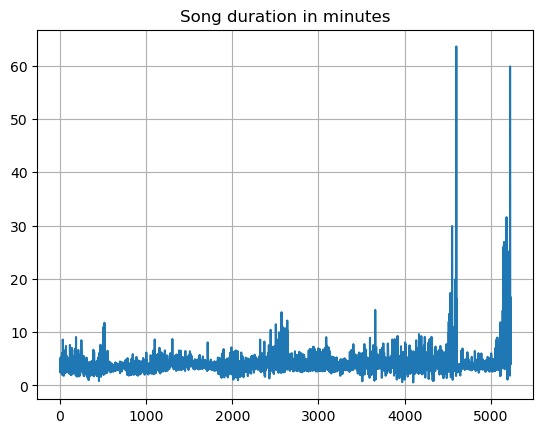

In [1793]:
df = songs2_cluster.set_index(['song_name','artist']).drop(columns=['id','html'])

(df['duration_ms'].reset_index(drop=True)/(60*1000)).plot()
plt.grid()
plt.title('Song duration in minutes');

### Song speechiness

Plot overall speechines of full dataset.

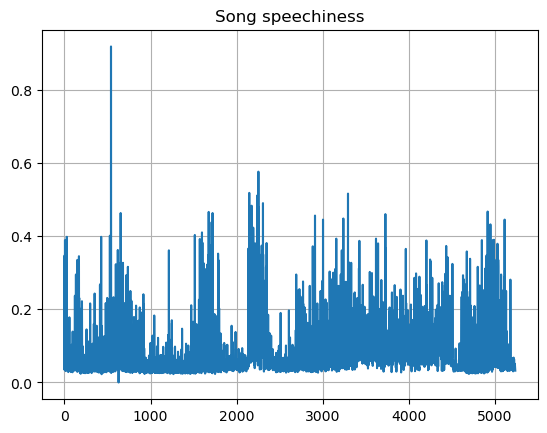

In [1815]:
df = songs2_cluster.set_index(['song_name','artist']).drop(columns=['id','html'])

s = df['speechiness'].reset_index(drop=True)
s.plot()
plt.grid()
plt.title('Song speechiness');

### Song time signature

Plot overall time signatures of full dataset.

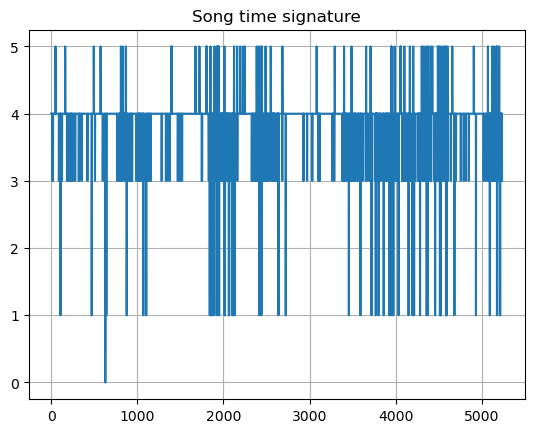

In [1823]:
df = songs2_cluster.set_index(['song_name','artist']).drop(columns=['id','html'])

s = df['time_signature'].reset_index(drop=True)
s.plot()
plt.grid()
plt.title('Song time signature');

## Scatterplot Clusters

Do an examplary scatter of two audio features.

<Axes: xlabel='danceability', ylabel='energy'>

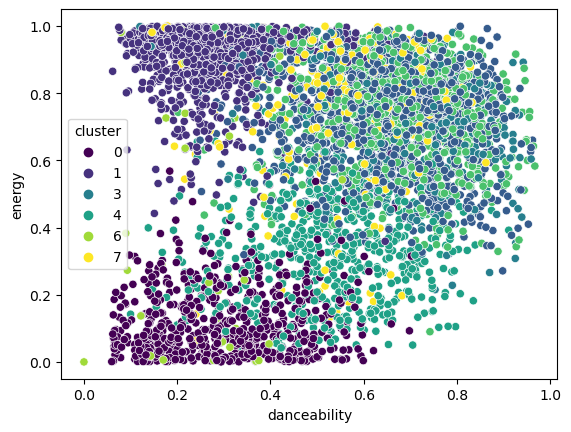

In [1502]:
df = songs2_cluster.set_index(['song_name','artist'])

sns.scatterplot(
    data = df,
    x = 'danceability',
    y = 'energy',
    hue = 'cluster',
    palette = 'viridis'
)

## Cluster using inertia and silhouette

Use inertia an silhouette score to decide upon a ideal number of clusters for the dataset.

### Inertia / Elbow Method

Looking at inertia over cluster count.<br>
Trying to narrow down the "elbow-position" by also looking at the *change of inertia* per additional cluster.

Text(0.5, 1.0, 'Inertia over cluster-count')

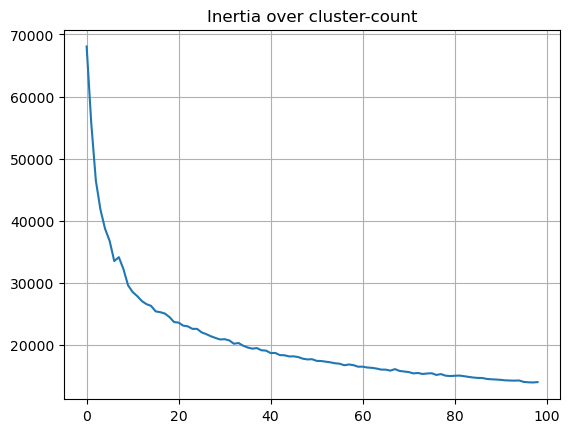

In [1384]:
df = songs2.drop(columns=['song_name','artist','id','html','duration_ms']);

scaler = StandardScaler().set_output(transform="pandas");

df_scaled = scaler.fit_transform(df)

inertia_list = []

for i in range(1,100):
    # Cluster values
    my_kmeans = KMeans(n_clusters = i, n_init='auto')
    # Fit model to scaled data
    my_kmeans.fit(df_scaled)
    #
    inertia_list.append(round(my_kmeans.inertia_))
    
plt.plot(inertia_list)
plt.grid()
plt.title('Inertia over cluster-count')

569

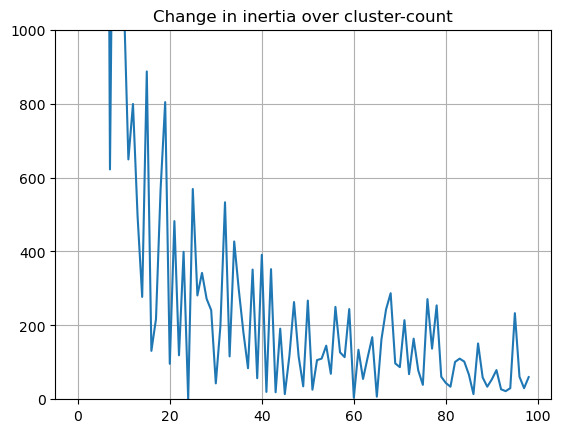

In [1388]:
inertia_delta = abs(np.array(inertia_list + [0]) - np.array([0] + inertia_list))
plt.plot(inertia_delta[:-1:])
plt.ylim(0,1000)
plt.grid()
plt.title('Change in inertia over cluster-count')

# np.argsort(inertia_delta[20:40])
inertia_delta[25] # -->Highest change rate at k==25

### Silhouette Coefficient

The Silhouette coefficient helps to decide wether clusters overlap each other.

Text(0.5, 1.0, 'Silhouette coefficient over cluster count')

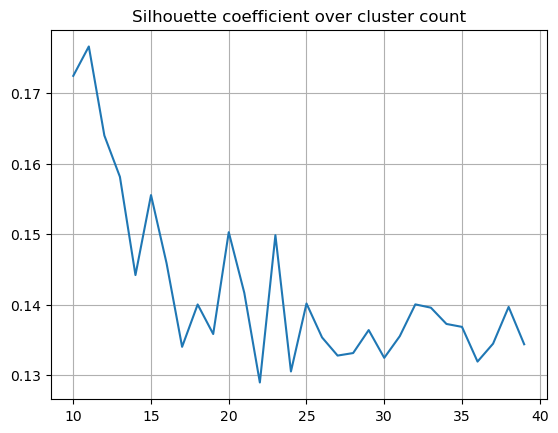

In [1390]:
df = songs2.drop(columns=['song_name','artist','id','html','duration_ms']);

scaler = StandardScaler().set_output(transform="pandas");

df_scaled = scaler.fit_transform(df)

silscore_list = []

# Range determined from former elbow method
krange = range(10,40)
for i in krange:
    # Cluster values
    my_kmeans = KMeans(n_clusters = i, n_init='auto')
    # Fit model to scaled data
    my_kmeans.fit(df_scaled)
    #
    silscore_list.append(silhouette_score(df_scaled, my_kmeans.labels_))
    
plt.plot(krange,silscore_list)
plt.grid()
plt.title('Silhouette coefficient over cluster count')

### Results - Overview

Using the Elbow Method a range of clusters between 20 and 40 was determined (ideally 25).<br>
Taking results from the silhouette coefficient into account, 22 clusters seem optimal.

In [31]:
df = songs2.drop(columns=['song_name','artist','id','html','duration_ms']);

scaler = StandardScaler().set_output(transform="pandas");

df_scaled = scaler.fit_transform(df)

# Cluster values
my_kmeans = KMeans(n_clusters = 22, n_init='auto')
# Fit model to scaled data
my_kmeans.fit(df_scaled)

songs2_cluster2 = songs2_cluster
songs2_cluster2['cluster'] = my_kmeans.labels_

makehtmltable(songs2_cluster2[['song_name','artist','html','cluster']].sample(20).sort_values('cluster'))

,Song Name,Artist,HTML,Cluster
0,No Particular Place To Go - Stereo Remix,Chuck Berry,[Link to Song],0
1,You Can't Hurry Love - 2016 Remaster,Phil Collins,[Link to Song],0
2,Firework,Katy Perry,[Link to Song],0
3,Aquí Está Tu Caldo,Daddy Yankee,[Link to Song],0
4,"Mazurka in A Minor, Op. 17 No. 4",Frédéric Chopin,[Link to Song],3
5,"Daphnis et Chloé, M. 57 - Ballet en 3 parties (complete) / Première partie: Introduction et danse religieuse",Maurice Ravel,[Link to Song],3
6,Be My Baby,The Ronettes,[Link to Song],4
7,Angelito,Don Omar,[Link to Song],5
8,Rock Your Body,Justin Timberlake,[Link to Song],5
9,Nothing To Be Done,The Pastels,[Link to Song],6


### Results - Cluster Samples

Take a look at some random samples from one specific cluster.

In [1394]:
df = songs2_cluster2[songs2_cluster2['cluster']==6][['song_name','artist','html','cluster']].sample(20)
makehtmltable(df)

,Song Name,Artist,HTML,Cluster
0,Solace,Necrosanct,[Link to Song],6
1,Biohazard,Massacre,[Link to Song],6
2,Evoked Doom,Cenotaph,[Link to Song],6
3,Blinded By Fear,At The Gates,[Link to Song],6
4,Paradox Alley,Benediction,[Link to Song],6
5,Homage For Satan,Deicide,[Link to Song],6
6,You'll Never See,Grave,[Link to Song],6
7,Pitbull Grin,Broken Hope,[Link to Song],6
8,Astronomia,Vicetone,[Link to Song],6
9,La Pedregada,Univers,[Link to Song],6


### Results - Cluster Sizes

Take a look at the cluster sizes.<br>
Business requirements say no cluster should be smaller than 50 songs.

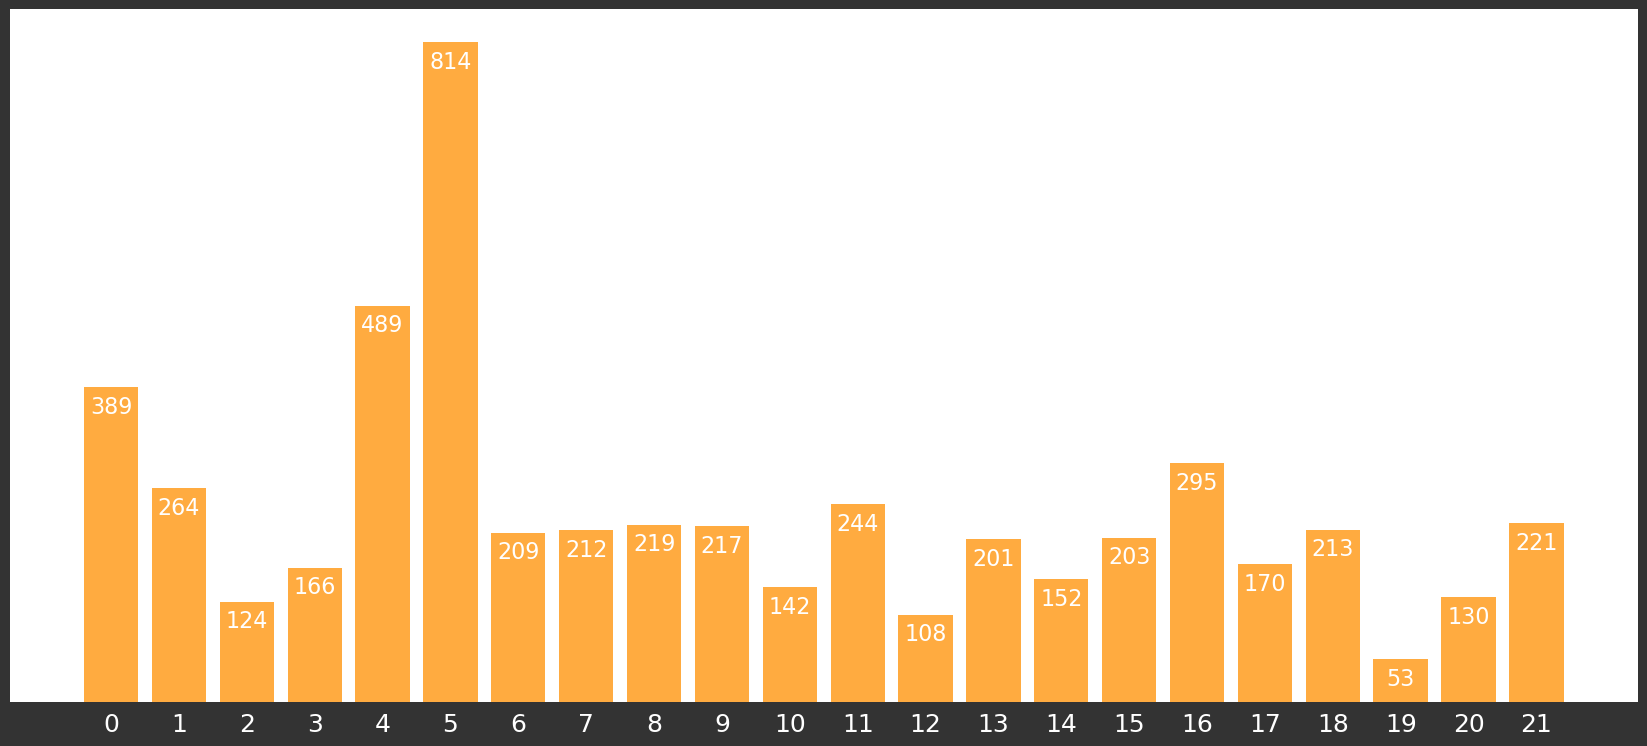

In [2765]:
df = songs2_cluster2['cluster']
df2 = df.value_counts().reset_index()

plt.figure(figsize=(21,9))
plt.bar(df2['cluster'],df2['count'],color=np.array([255,171,64])/255)
# plt.title('Cluster sizes')

plt.xticks(range(len(df2)))
plt.xticks(fontsize=18,color='White')

plt.gcf().set_facecolor(np.ones([1,3])*0.2)

for index, row in df2.iterrows():
    plt.text(row['cluster'], row['count']-32, str(row['count']), color='white', ha="center", fontsize=16)
    
# Hide axis
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# Hide the x-axis ticks but keep the labels
plt.gca().tick_params(axis='x', which='both', bottom=False, top=False)
#
plt.gca().spines['bottom'].set_visible(False)

plt.savefig('test.png',transparent=True,dpi=200)

### Results - Cluster Scatterplot (DOTS)

Make a scatterplot with each dot representing one individual song.<br>
Color the dots differently per assigned cluster.<br>
Code/Plot is used for visualising the process of clustering:<br>
1. All dots in same color indicating no present knowledge about the songs.
2. Dots in cluster-color, however distributed "randomly" (or rather just in the order they also appear in the dataset). Indicating features have been identified, but clusters are not final yet.
3. Dots in cluster-color and ordered along "stripes" on the grid, indicating similar songs have been grouped together.

See final presentation for the different types of plots.

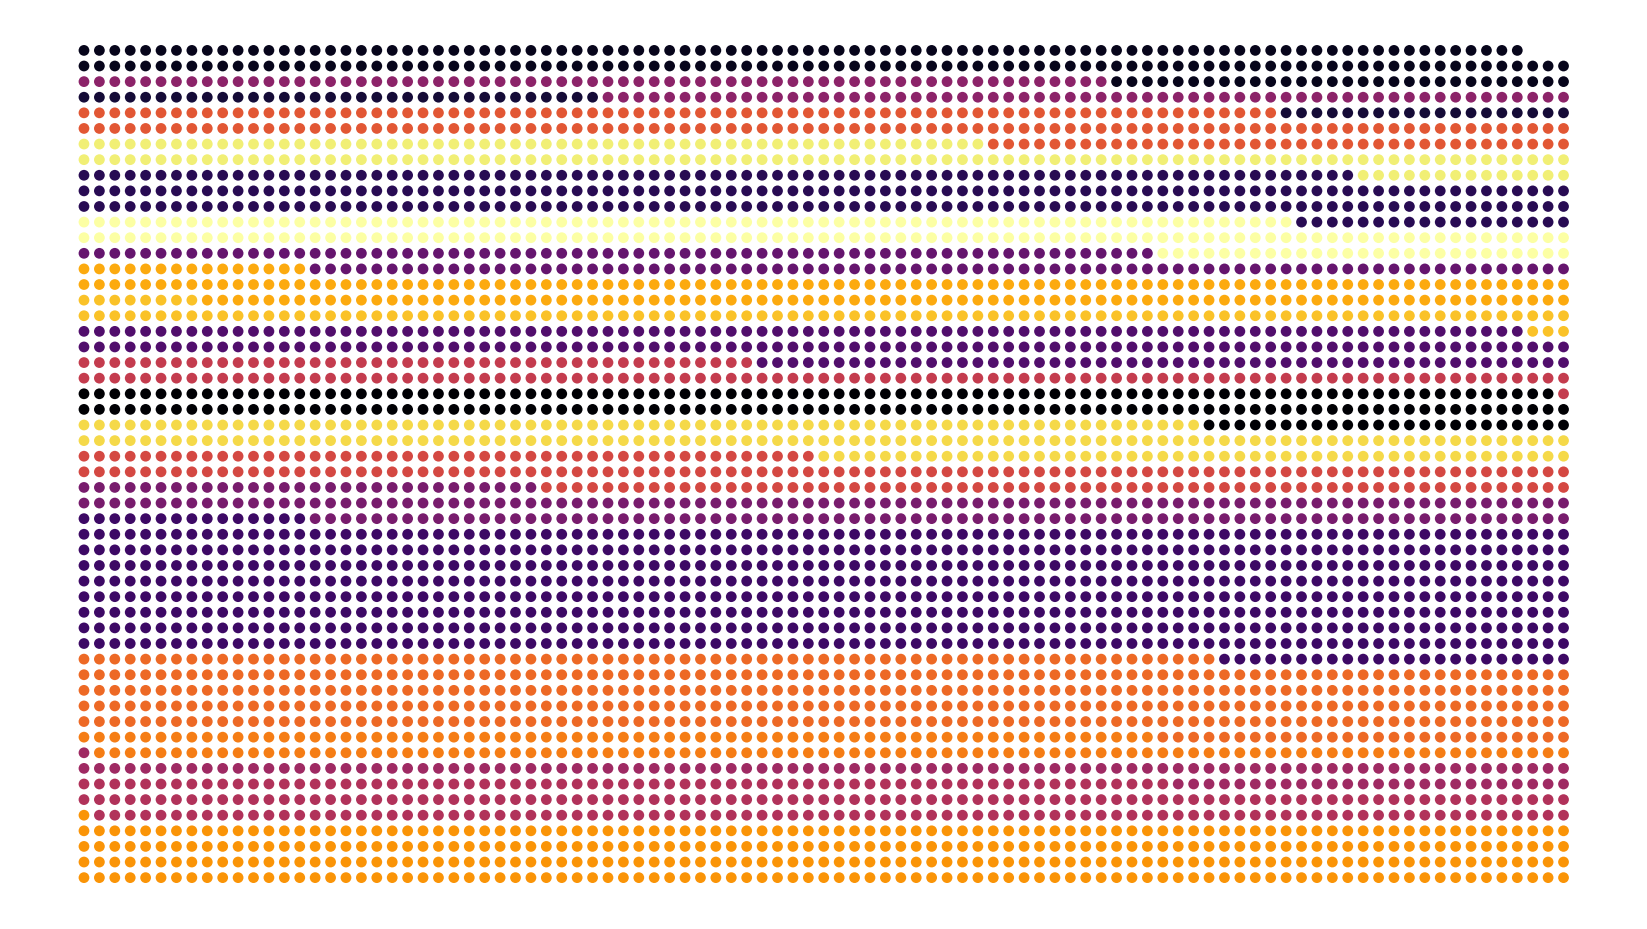

In [2228]:
df = songs2_cluster2['cluster'].sort_values()

# --- SHUFFLE CLUSTER-LIST
# Create list of cluster-values (e.g. 0...21)
cl_list = list(range(df.max()+1))
# Shuffle that list in place
random.seed(123)
random.shuffle(cl_list)
# Take lists from original series of cluster value
# and addrees cl_list at respective index. Get shuffled value in return
df = [cl_list[i] for i in df]

nx = int(np.ceil(np.sqrt(len(df)*16/9)))
ny = int(np.ceil(len(df)/nx))

xvals = np.linspace(0,nx-1,nx).tolist()*ny
yvals = np.floor(np.linspace(0,ny,(ny*nx)+1)).tolist()

xvals = xvals[:len(df)]
yvals = yvals[:len(df)]

df2 = pd.DataFrame({'xvals':xvals,'yvals':yvals,'cluster':df})


plt.figure(figsize=(21,21/1.777))
ax = sns.scatterplot(
    data = df2,
    x = 'xvals',
    y = 'yvals',
    hue = 'cluster',
    palette = 'inferno',
    # color = np.array([255,171,64])/255,
    linewidth=0,
    s = 60
)
if(ax.get_legend()!=None):
    ax.get_legend().set_visible(False)
ax.set_facecolor(0.1*np.ones([1,3]))

# Remove frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Remove ticks
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

# Remove axes
plt.axis('off')

# Save as PNG with Alpha
# plt.savefig('test.png',transparent=True)

## Cluster Analysis using Gemini AI

Try using Google Gemini AI to get an assessement of what the top 5 genres in a cluster are.<br>
Do this by sending all artists of one cluster to Gemini AI and asking it to name the top 5 genres.

In [1458]:
project_id = "wbsproject01"
location = "europe-west2"

vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

# Setup Gemini
def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)


# Initial string:
str_init = "What type of music do the following artists have in common? Please respond by only listing the top 5 genres that come to your mind. Nothing else.\n\n"

# Initialize list of responses
response_list = []

for i in range(songs2_cluster2['cluster'].max()+1):
# for i in range(2):
    # Get artist-list from current cluster
    df = songs2_cluster2[songs2_cluster2['cluster']==i]['artist'].unique()
    # Generate prompt from init and artist list
    prompt = str_init + str(list(df)).replace("'"," ").replace("["," ").replace("]"," ").strip()
    # Get Gemini response
    response = get_chat_response(chat, prompt)
    # Store response in response list
    response_list.append(response)
    # Wait a bit before next request
    time.sleep(5)
    
response_list

['## Top 5 Genres:\n\n1. **Pop**\n2. **Rock**\n3. **Latin**\n4. **Dance**\n5. **Electronic**',
 '## Top 5 Genres:\n\n1. **Metal**\n2. **Electronic**\n3. **Grindcore**\n4. **Doom Metal**\n5. **Death Metal**',
 '## Top 5 Genres:\n\n1. **Classical**\n2. **Ambient**\n3. **Drone**\n4. **Minimalism**\n5. **Experimental**',
 '## Top 5 Genres:\n\n1. **Classical**\n2. **Jazz**\n3. **Ambient**\n4. **Minimalism**\n5. **Chillout**',
 '## Top 5 Genres:\n\n1. **Pop**\n2. **Rock**\n3. **Dance**\n4. **Electronic**\n5. **Latin**',
 '## Top 5 Genres:\n\n1. **Pop**\n2. **Electronic**\n3. **Dance**\n4. **Hip-Hop**\n5. **Latin**',
 '## Top 5 Genres:\n\n1. **Metal**\n2. **Death Metal**\n3. **Black Metal**\n4. **Grindcore**\n5. **Doom Metal**',
 '## Top 5 Genres:\n\n1. **Pop**\n2. **Brazilian**\n3. **Jazz**\n4. **Latin**\n5. **Electronic**',
 '## Top 5 Genres:\n\n1. **Indie**\n2. **Pop**\n3. **Rock**\n4. **Hip-Hop**\n5. **Latin**',
 '## Top 5 Genres:\n\n1. **Classical**\n2. **Ambient**\n3. **Jazz**\n4. **Pia

## -------------------------------------------

THE FOLLOWING PART IS ONLY KEPT FOR DOCUMENTATION BUT SHOULD NOT ACTUALLY BE EXECUTED AGAIN.<br>
<br>
Using Gemini AI to get genre-labels per individual artist.<br>
Do this by sending artist-names of the full dataset to Gemini and asking it which genre the artist belongs to.<br>
<br>
Problems:<br>
1. Gemini might not assess the full list you're sending
2. Gemini might rejet a request because it deems artists "harmful" (e.g. due to possible sexual or racist content)
3. Gemini might not give you the correct genre for an artist.
<br><br>

How I solved it:<br>

1. Only send chunks of the full artist list to Gemini (e.g. 50%)
2. See if it works, then send another chunk.
3. Since Gemini's responses might differ with each prompt, adjust the post-processing of it's response.
4. Join all the responses in a combined CSV until all artists have a genre.
<br><br>

The final artist-genre CSV is in the "data"-folder.<br>
Beware: As said above, some artists have incorrectly assigend genres, e.g. "Carnage" (Death Metal) is assigned to Trap-Music.

## Get genre per artist using Gemini AI

### Import known artists

In [531]:
artists_unique = sorted(songs2_cluster2['artist'].unique())

knownartists_df = pd.read_csv('artist_to_genre.csv')['artist'].unique()
remaining_artists_df = [item for item in artists_unique if item not in list(knownartists_df)]

# print(len(knownartists_df))
# print(len(songs2_cluster2['artist'].unique()))

remaining_artists_df

['Axwell /\\ Ingrosso']

### Try all artists at once

In [333]:
project_id = "wbsproject01"
location = "europe-west2"

vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

# Setup Gemini
def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)


# ----- -----
# Initial string:
str_init = """in the following you'll receive a list of artist-names.\n
                please respond with a list of genres, one per artist.\n
                example:\n
                my prompt: 'metallica', 'no angels', 'bob marley'\n
                your response: 'metal', 'pop', 'reggae'"
"""
prompt = str_init

get_chat_response(chat, prompt)

# ----- -----
#
str_init = "Okay, here's the list:\n\n"

# df = songs2_cluster2['artist'].unique()
# prompt = str_init + str(sorted(list(df)[0:int(len(df)/2)])).replace("\""," ")
df = remaining_artists_df
prompt = str_init + str(df).replace("\""," ")

response_artist_genre_full = get_chat_response(chat, prompt)
response_artist_genre_full

"Here's a list of genres, one per artist:\n\n*   Axwell /\\\\ Ingrosso: Progressive House\n*   Franco  El Gorilla : Reggaeton\n*   Héctor  El Father : Reggaeton\n*   Lee  Scratch  Perry: Reggae\n*   Tito  El Bambino : Reggaeton \n"


### Get 0...50% artists

In [313]:
project_id = "wbsproject01"
location = "europe-west2"

vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

# Setup Gemini
def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)


# ----- -----
# Initial string:
str_init = """in the following you'll receive a list of artist-names.\n
                please respond with a list of genres, one per artist.\n
                example:\n
                my prompt: 'metallica', 'no angels', 'bob marley'\n
                your response: 'metal', 'pop', 'reggae'"
"""
prompt = str_init

get_chat_response(chat, prompt)

# ----- -----
#
str_init = "Okay, here's the list:\n\n"

# df = songs2_cluster2['artist'].unique()
# prompt = str_init + str(sorted(list(df)[0:int(len(df)/2)])).replace("\""," ")
df = remaining_artists_df
prompt = str_init + str(df[0:int(len(df)/2)]).replace("\""," ")

response_artist_genre1 = get_chat_response(chat, prompt)
response_artist_genre1

ValueError: Content roles do not match: model != 

### Get 50...75% artists

In [311]:
# ----- -----
#
str_init = "Here's another list. Please do the same again:\n\n"

# df = songs2_cluster2['artist'].unique()
# prompt = str_init + str(sorted(list(df)[step:step+int(step/2)])).replace("\""," ")
df = remaining_artists_df
step = int(len(df)/2)
prompt = str_init + str(df[step:step+int(step/2)]).replace("\""," ")

response_artist_genre2 = get_chat_response(chat, prompt)
response_artist_genre2

ValueError: Content roles do not match: model != 

### Get 75...100% artists

In [278]:
# ----- -----
#
str_init = "Here's another list. Please do the same again:\n\n"

# df = songs2_cluster2['artist'].unique()
# prompt = str_init + str(sorted(list(df)[step+int(step/2):len(df)])).replace("\""," ")
df = remaining_artists_df
step = int(len(df)/2)
prompt = str_init + str(df[step+int(step/2):len(df)]).replace("\""," ")

response_artist_genre3 = get_chat_response(chat, prompt)
response_artist_genre3

'## Genre List for the Second Batch:\n\n* Perry Como: Traditional Pop\n* Pet Shop Boys: Synthpop\n* Pete Krebs & The Kung Pao Chi: Funk\n* Peter And Gordon: Pop\n* Peter Andre: Pop\n* Royce Da 5\'9": Hip hop\n* Skrillex: Dubstep\n* Slumber Party: Shoegaze\n* Sly & The Family Stone: Funk\n* Small Faces: Rock\n* Smith Westerns: Indie rock\n* Smokey Robinson & The Miracles: Motown\n* Som Ibérico: Indie pop\n* Sonny & Cher: Pop\n* Sonny & The Sunsets: Surf rock\n* Sonny Rollins: Jazz\n* Sophia George: Pop\n* Sophie Milman: Jazz\n* Soulja Boy: Hip hop\n* Spandau Ballet: New romantic\n* Spice Girls: Pop\n* Spin Doctors: Rock\n* Sr. Chinarro: Indie pop\n* Stan Getz: Jazz\n* Star Slinger: Electro house\n* Starland Vocal Band: Pop\n* Starley: Pop\n* Starship: Rock\n* Steely Dan: Rock\n* Steve Aoki: Electro house\n* Steve Miller Band: Rock\n* Steve Winwood: Rock\n* Stevie Wonder: R&B\n* Stone Poneys: Folk\n* Stormzy: Grime\n* Subsona: Indie pop\n* Sufjan Stevens: Indie folk\n* Sugababes: Pop\n* 

### Make Dataframe Artist-Genre

#### Gemini answers with Artist | Genre

In [509]:
artist_to_genre = {'artist':[],'genre':[]}

# Select character for splitting artist and genre from the response
split_char = ":"

for ag in response_artist_genre_full.split("\n")[1:]:
    entry = ag.split(split_char)
    if(len(entry)==2):
        artist_to_genre['artist'].append(entry[0][2:].strip())
        artist_to_genre['genre'].append(entry[1].strip())

# for ag in response_artist_genre2.split("\n")[6:]:
#     entry = ag.split(split_char)
#     if(len(entry)==2):
#         artist_to_genre['artist'].append(entry[0].strip())
#         artist_to_genre['genre'].append(entry[1].strip())

# for ag in response_artist_genre3.split("\n")[6:]:
#     entry = ag.split(split_char)
#     if(len(entry)==2):
#         artist_to_genre['artist'].append(entry[0].strip())
#         artist_to_genre['genre'].append(entry[1].strip())        
        
artist_to_genre_df = pd.DataFrame(artist_to_genre)

artist_to_genre_df

,artist,genre
0,Axwell /\\ Ingrosso,Progressive House
1,Franco El Gorilla,Reggaeton
2,Héctor El Father,Reggaeton
3,Lee Scratch Perry,Reggae
4,Tito El Bambino,Reggaeton


#### Gemini answers with Artist : Genre and Numbering

In [224]:
AL = []
AL.append([re.sub(r'^\d+\.\s*', '', item) for item in response_artist_genre1.split("\n")[2:]])
AL.append([re.sub(r'^\d+\.\s*', '', item) for item in response_artist_genre2.split("\n")[2:]])
AL.append([re.sub(r'^\d+\.\s*', '', item) for item in response_artist_genre3.split("\n")[2:]])

In [237]:
artist_to_genre = {'artist':[],'genre':[]}

for L in AL:
    for a_string in L:
        L2 = a_string.split(":")
        if (len(L2) == 2):
            artist_to_genre['artist'].append(L2[0])
            artist_to_genre['genre'].append(L2[1])

artist_to_genre_df = pd.DataFrame(artist_to_genre)

artist_to_genre_df

,artist,genre
0,2PM,K-Pop
1,2Pac,Hip-hop
2,7 Zwerge,German folk
3,Aaron Smith,House
4,Axwell / Ingrosso,House
...,...,...
433,Zé Maurício Machline,Jazz
434,a-ha,Synthpop
435,benny blanco,Pop
436,blackbear,Hip-hop


#### Gemini answers with Arist : Genre and *-formatting

In [301]:
AL = []
AL.append([item[2:] for item in response_artist_genre1.split("\n")[2:]])
AL.append([item[4:] for item in response_artist_genre2.split("\n")[2:]])
AL.append([item[2:] for item in response_artist_genre3.split("\n")[2:]])

In [303]:
artist_to_genre = {'artist':[],'genre':[]}

for L in AL:
    for a_string in L:
        L2 = a_string.split(":")
        if (len(L2) == 2):
            artist_to_genre['artist'].append(L2[0])
            artist_to_genre['genre'].append(L2[1])

artist_to_genre_df = pd.DataFrame(artist_to_genre)

artist_to_genre_df

,artist,genre
0,Axwell /\\ Ingrosso,House
1,Franco El Gorilla,Reggaeton
2,Héctor El Father,Reggaeton
3,Judy Collins,Folk
4,Julia Michaels,Pop
...,...,...
289,The Be Good Tanyas,Folk
290,The Beach Boys,Surf rock
291,The Beatles,Rock
292,The Bellamy Brothers,Country


### Concat DataFrame and export CSV

In [517]:
df = pd.concat([pd.read_csv('artist_to_genre.csv')[['artist','genre']], artist_to_genre_df]).sort_values('artist',ascending=True).drop_duplicates('artist').reset_index(drop=True)

df.to_csv('artist_to_genre.csv',index=False)

#### Experimenting...

In [519]:
# select = ~pd.Series(songs2_cluster2['artist'].unique()).isin(df['artist'])
[item for item in songs2_cluster2['artist'].unique() if item not in list(df['artist'])]
# sorted(songs2_cluster2['artist'].unique())
# list(df['artist'])

['Axwell /\\ Ingrosso',
 'Lee "Scratch" Perry',
 'Héctor "El Father"',
 'Tito "El Bambino"',
 'Franco "El Gorilla"']

## Get greater genres using Gemini AI

**Not used because Gemini's replies are not consistent and thus not usable!**<br>
e.g.<br>
Soundtrack - Rock<br>
and if 235 genres are entered it sometimes returns 178 genres and sometimes returns 312 genres (examplary)

In [1040]:
project_id = "wbsproject01"
location = "europe-west2"

# --- INITIALIZE GEMINI
vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

# --- SETUP GEMINI SESSION
def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)


# --- INITIALIZE QUERY
str_init = """Music is made of genres and those genres can contain subgenres.\n
              For example "Deutschrap" would be considered a subgenre of "Rap" as well as "Latin Pop" or "Traditional Pop" would be considered a subgenre of "Pop".\n
              "Pop" itself is not a subgenre and thereby would just be of category "Pop" again.\n
              I will now send you a list of 235 genres and subgenres.\n
              Keeping in mind what I just said, could you please return me a list that assigns the greater genres to it?\n
              So for each genre or subgenre I send to you I want to have the greater genre in return as an answer.
              Don't add any additional parts like explanations, numbering or notes to your answer.\n
              Keep it clean an concise. Are you ready?
              """
prompt = str_init

# Get GEMINIs initial response
get_chat_response(chat, prompt)

# Get existing artist-genre combinations
df = pd.read_csv('artist_to_genre.csv')

# --- ACTUAL QUERY
str_init = "Okay, here's the list:\n\n"

# Get unique genres from DF
str_genres = re.sub("['\[\]]","",str(list(df['genre'].unique())))

# Make prompt
prompt = str_init + str_genres
# Get GEMINIs response
response_greater_genre = get_chat_response(chat, prompt)


response_greater_genre

'Pop, Rock, Classical, Pop, Hip-hop, Rock, Folk, Pop, Electronic, Classical, Electronic, Metal, Electronic, World, Rock, Electronic, World, Metal, Electronic, Electronic, Metal, Metal, Jazz, R&B, R&B, Electronic, Rock, Jazz, Jazz, Latin, Reggae, Reggae, Rock, Other, Metal, Country, Christian, World, Electronic, Pop, Folk, Latin, Classical, Latin, Electronic, Electronic, Rock, Pop, Jazz, Metal, Latin, Pop, Hip-hop, Hip-hop, Disco, A Cappella, World, Pop, Pop, R&B, Electronic, Punk, Pop, Electronic, Dance, Electronic, Rock, Electronic, Classical, Jazz, Latin, Electronic, Metal, Industrial, Pop, Funk, Metal, Metal, Doo-wop, Soundtrack, Minimalism, Pop, Metal, Metal, Punk, Electronic, Electronic, World, World, Britpop, World, House, Rock, Indie, Electronic, Metal, Metal, R&B, Electronic, Afrobeat, Electronic, Blues, Choral, Metal, World, Grime, Metal, Pop, Big Beat, Trip Hop, Electronic, Metal, World, Rock, Rock, Flamenco, Jazz, Rock, Indie, Hip-hop, Metal, House, Minimal Music, World, Ele

END OF THE ARTIST/GENRE GATHERING PART

## -------------------------------------------

## Add genres to songs-table

Take the gathered artit-genre table and assign it to the dataset.

In [1462]:
# Add cluster genres to DF
songs2_cluster2['cluster_genres'] = [response_list[i] for i in songs2_cluster2['cluster']]

# Initialize artist_to_genre from former
artist_to_genre_df = pd.read_csv("data/artist_to_genre.csv")

# Merge artist_to_gerne to song-list, to get genre for each song
songs2_genres = songs2_cluster2.merge(artist_to_genre_df, how='left', on='artist').rename(columns={'genre':'artist_genre'})

songs2_genres_filtered = songs2_genres[~songs2_genres['artist_genre'].isna()]

# Output Sample
# songs2_genres[['song_name','artist','artist_genre']].sample(10)
songs2_genres_filtered[['song_name','artist','artist_genre']].sample(10)

,song_name,artist,artist_genre
498,La Pedregada,Univers,Pop
1747,"thank u, next",Ariana Grande,Pop
712,Lush Life,Zara Larsson,Pop
962,Cupid,Sam Cooke,Soul
1516,Ride On Time,Black Box,Eurodance
2350,My Curse,Killswitch Engage,Metalcore
3407,Graves of the Fathers,Cryptopsy,Technical Death Metal
1573,Circus,Britney Spears,Pop
4775,Joana,Peter Wackel,Schlager
3869,Jesters of Recession,Rottrevore,Black Metal


### Plot genre distribution

See how the different genres are spread across the dataset.

(5235, 18)


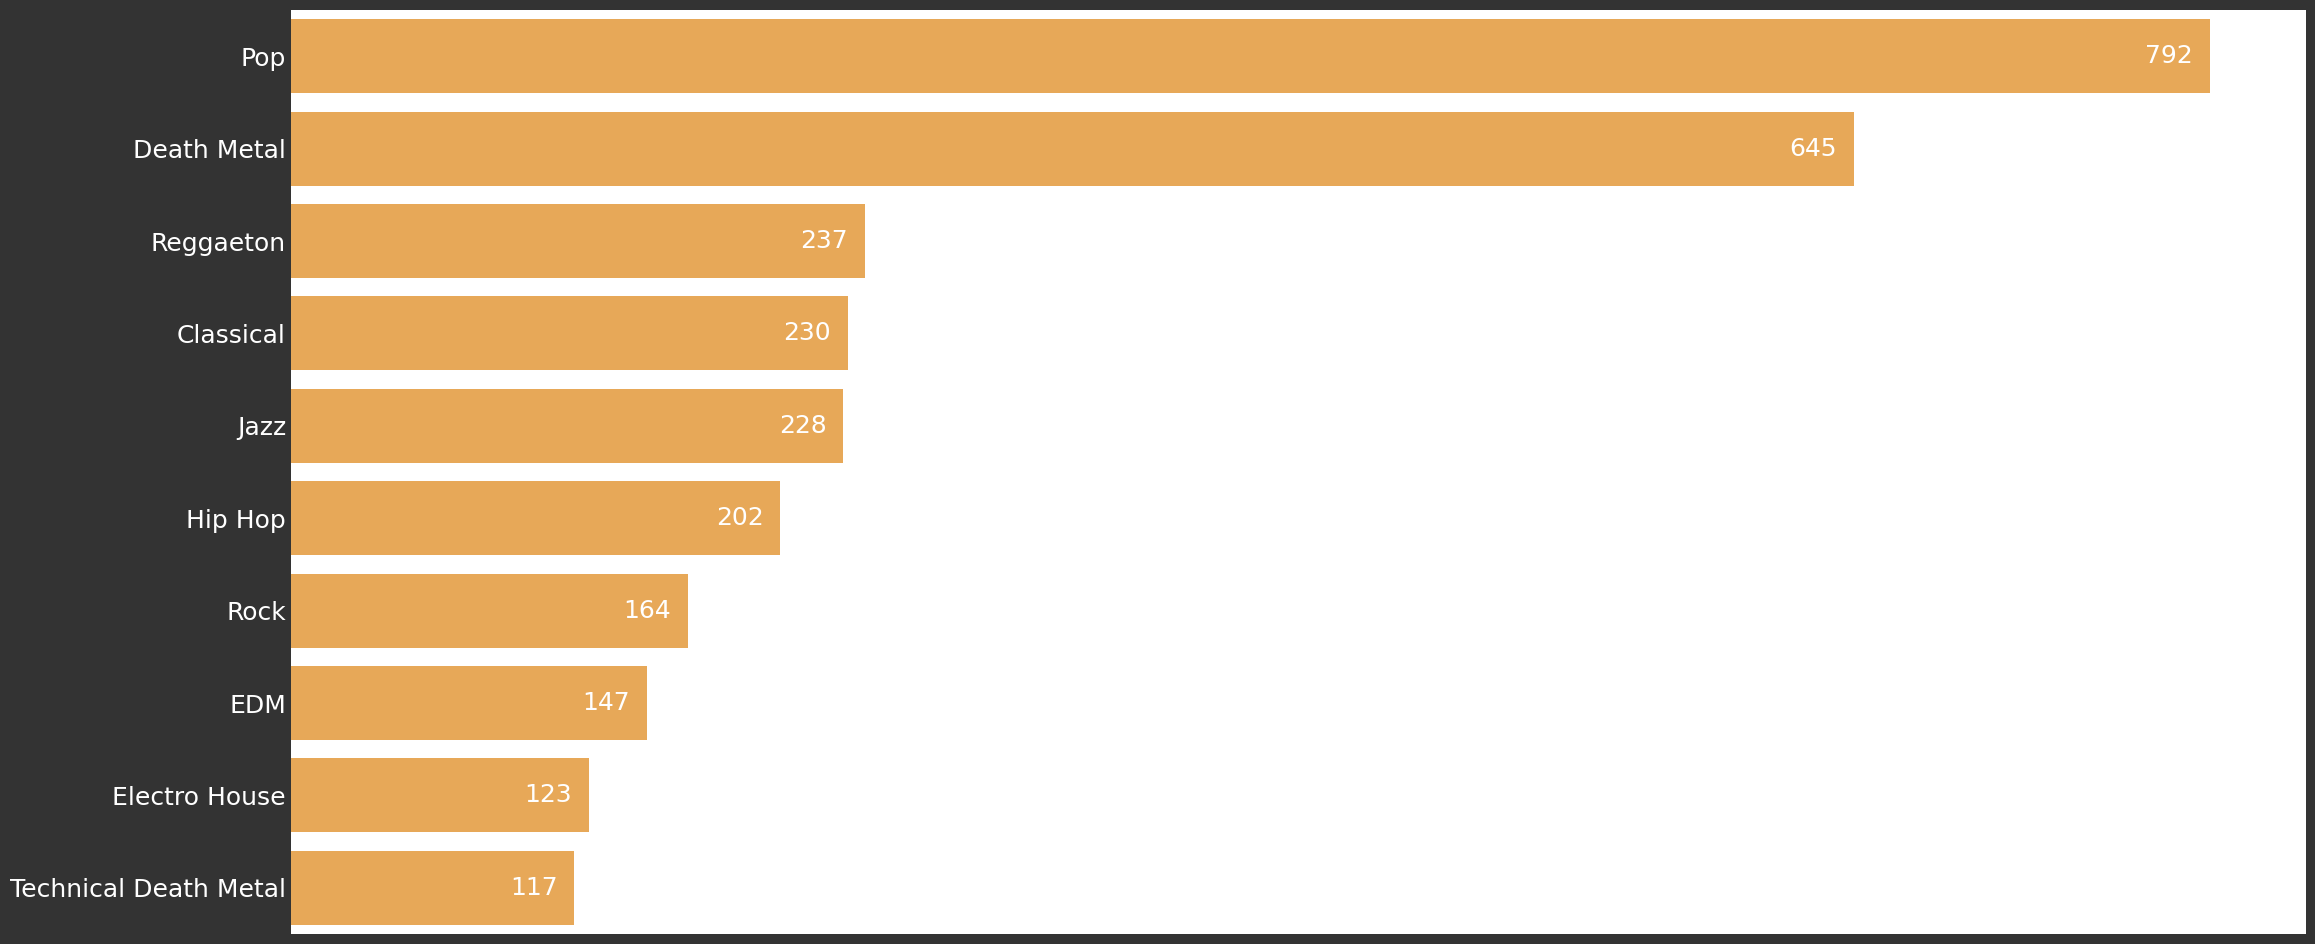

In [2854]:
# Get data
df = songs2_genres_filtered['artist_genre'].value_counts().reset_index().nlargest(10,'count')

# --- PLOTTING
plt.figure(figsize=(21,18*9/16))
ax = sns.barplot(
    data = df,
    x = 'count',
    y = 'artist_genre',
    color = np.array([255,171,64])/255
)
# print(df.reset_index())
# Get values from df and plot them on top of the bars
for index, row in df.reset_index().iterrows():
    plt.text(row['count']-7, row['index'], str(row['count']), color='White', ha="right", va="center", fontsize=18)

ax.set_xlabel('');
ax.set_ylabel('');
# ax.set_title('Amount of songs per genre');
plt.yticks(fontsize=18,color='White')
plt.gcf().set_facecolor(np.ones([1,3])*0.2)

# --- DECLUTTER PLOT
# Remove the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# Remove the xticks and xticklabels
plt.xticks([]);
plt.gca().yaxis.set_tick_params(length=0)

# Increase plot size, so y-labels are visible in exported PNG
plt.gcf().set_size_inches(26,12)

# Export plot as PNG
# plt.savefig('test.png',transparent=True)

### Radar Plot of main genres

Take the top 2 genres and radar-plot them above each other.<br>
Used to highlight differences in audio features for specific genres.

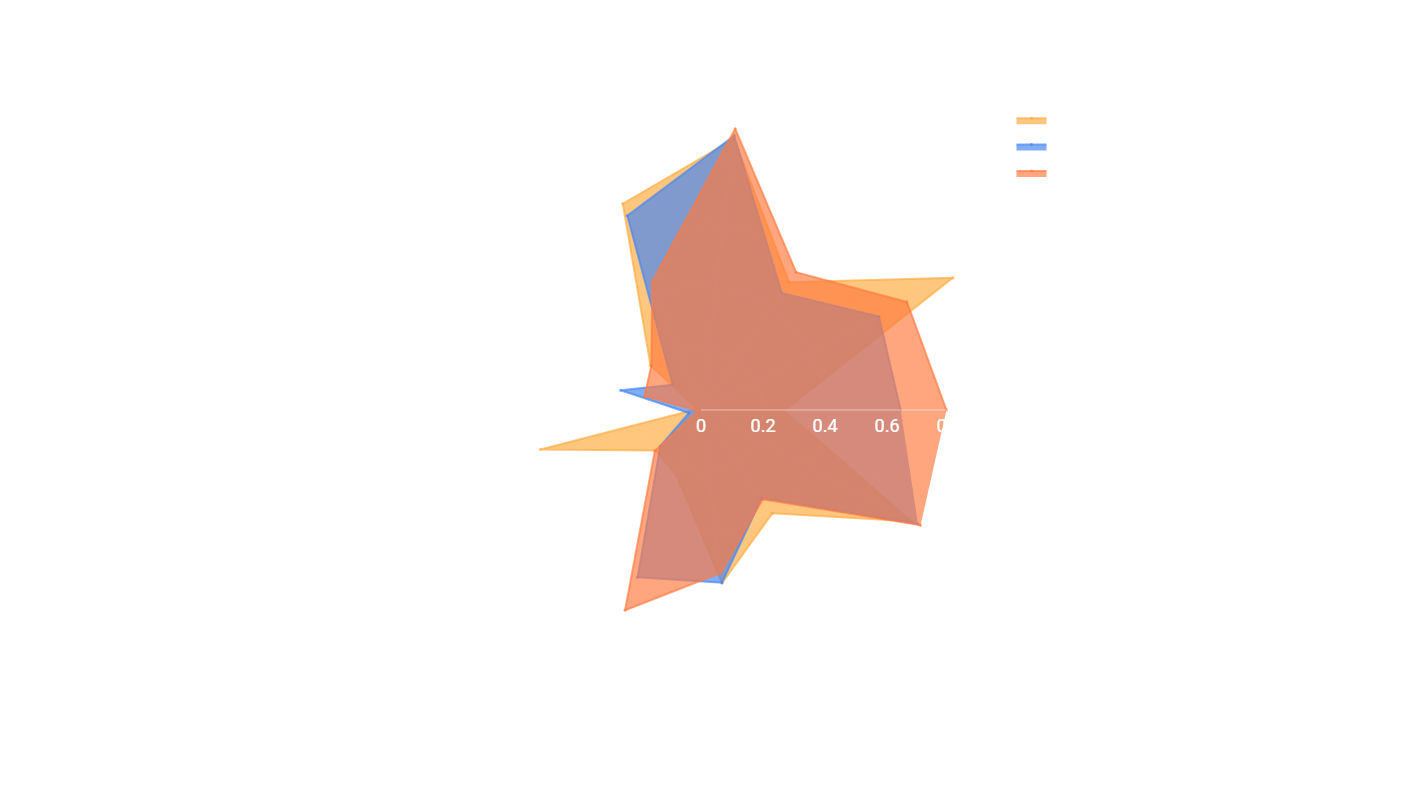

In [2897]:
# Get data
df = songs2_genres_filtered.drop(columns=['id','html','song_name','artist','cluster_genres','cluster'])

# Preselect the genres for the plot
df = df[df['artist_genre'].isin(['Death Metal','Pop','Reggaeton'])]

# Save a DF without artist genre for later
df_toscale = df.drop(columns='artist_genre')
# Initialize a scaler object
minmax = MinMaxScaler(feature_range=(0,1))
# scale the DF without artist_genre to 0...1 range (can't use genre because it's a string and doesn't make sense for scaling)
df_scale = minmax.fit_transform(df_toscale)
# Convert resulting array back to pandas-DF
# (take index and column-information from previously stored DF)
df_scale = pd.DataFrame(df_scale, index=df_toscale.index, columns=df_toscale.columns)
# Add artist-column back to DF
df_scale['artist_genre'] = df['artist_genre']
# Group results by genre and get average audio features
df2 = df_scale.groupby('artist_genre').mean()

# Initialize trace objects list
trace_objects = []

# Adaptive alpha value for coloring, depening on number of plotted genres
alpha = (df2.shape[0]-1)/df2.shape[0]
# Set colors for the individual genres (in accordance with final presentation colors)
colors = [f'rgba(255, 171, 64, {alpha})', f'rgba(66, 133, 244, {alpha})', f'rgba(255, 122, 64, {alpha})']

# --- GO THROUGH ALL GENRES AND ADD A PLOT
for c, genre in enumerate(df2.index):
    # Append plot object to list
    trace_objects.append(
        # Create scatterpolar plot
        go.Scatterpolar(
            # Get audio-feature values for radial information
            r = df2.loc[genre,:],
            # Get column-names for labeling
            theta = df2.columns,
            # Name of the current plot as it will appear in the legend
            name=genre,
            # Add fill-color to the shapes
            fill='toself',
            fillcolor=colors[c],
            # Set marker-color and fontsize
            marker=dict(color=colors[c],size=3),
            # Set linewidth of shapes
            line=dict(width=2)
        )
    )

# Add figure-element
fig = go.Figure()
# Add the scatterpolar-elements to the figure
fig.add_traces(trace_objects)

# --- ADJUST APPEARANCE
fig.update_layout(
    # Add plot-title
    # title_text = 'Main genres Pop & Death Metal compared by audio features',
    # Set plot-size in pixels
    height = 800,
    width = 1400,
    # Font-settings
    font=dict(
        color='white',
        family='Roboto',
        size=18
    ),
    # Background/Grid-Settings
    polar=dict(
        # Set background color
        bgcolor='rgba(0,0,0,0)',
        # Everything concerning radial elements...
        radialaxis=dict(
            # Toggle visibility
            visible=True,
            # Set size (should match max. values from data), comparable to ylim
            range=[0, 1],
            # Set line widths
            linewidth=0.5,
            gridwidth=0.5,
            # Hide labels at 0°-line
            showticklabels=False
        ),
        # Everything concerning angular elements...
        angularaxis=dict(
            # Set line widths
            linewidth=3,
            gridwidth=1
        ),
    ),
    # Set legend position
    legend=dict(
        x = 0.75,  # Set the x coordinate of the legend
        y = 1   # Set the y coordinate of the legend
    ),
    # Toggle legend visibility
    showlegend=True,
)

# Set background to transparent for exporting
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

# Show figure
fig.show()

### Get overall audio feature variance

Investigate variance of audio features for the full dataset.

instrumentalness    0.137504
acousticness        0.126820
energy              0.083211
valence             0.077181
danceability        0.047582
liveness            0.022340
speechiness         0.005071
dtype: float64

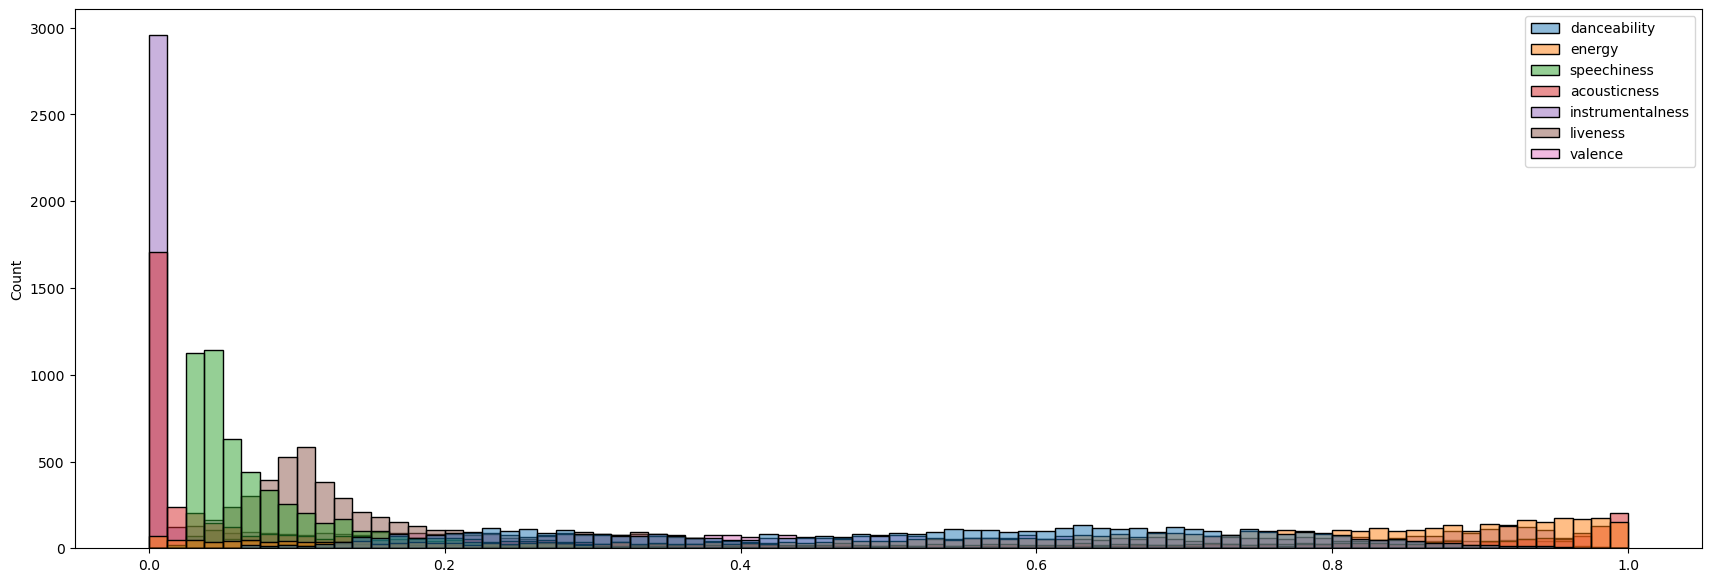

In [1480]:
# Get data
df = songs2_genres_filtered.drop(columns=['song_name','cluster','duration_ms','mode','key','time_signature','loudness','tempo','artist','id','html','cluster_genres'])
df2 = df.drop(columns='artist_genre')

# --- PLOTTING
plt.figure(figsize=(21,7))
# df2.hist(bins=50);
sns.histplot(
    # data = df2.drop(columns=['acousticness','instrumentalness']),
    data = df2,
    bins = 80
)
# --- PRINT VARIANCE VALUES
df2.std().sort_values(ascending=False)**2

### Plot acoustic features for a specific genre
Valence = musical positiveness conveyed by a track

Text(0.5, 1.0, 'Audio feature distribution for Death Metal')

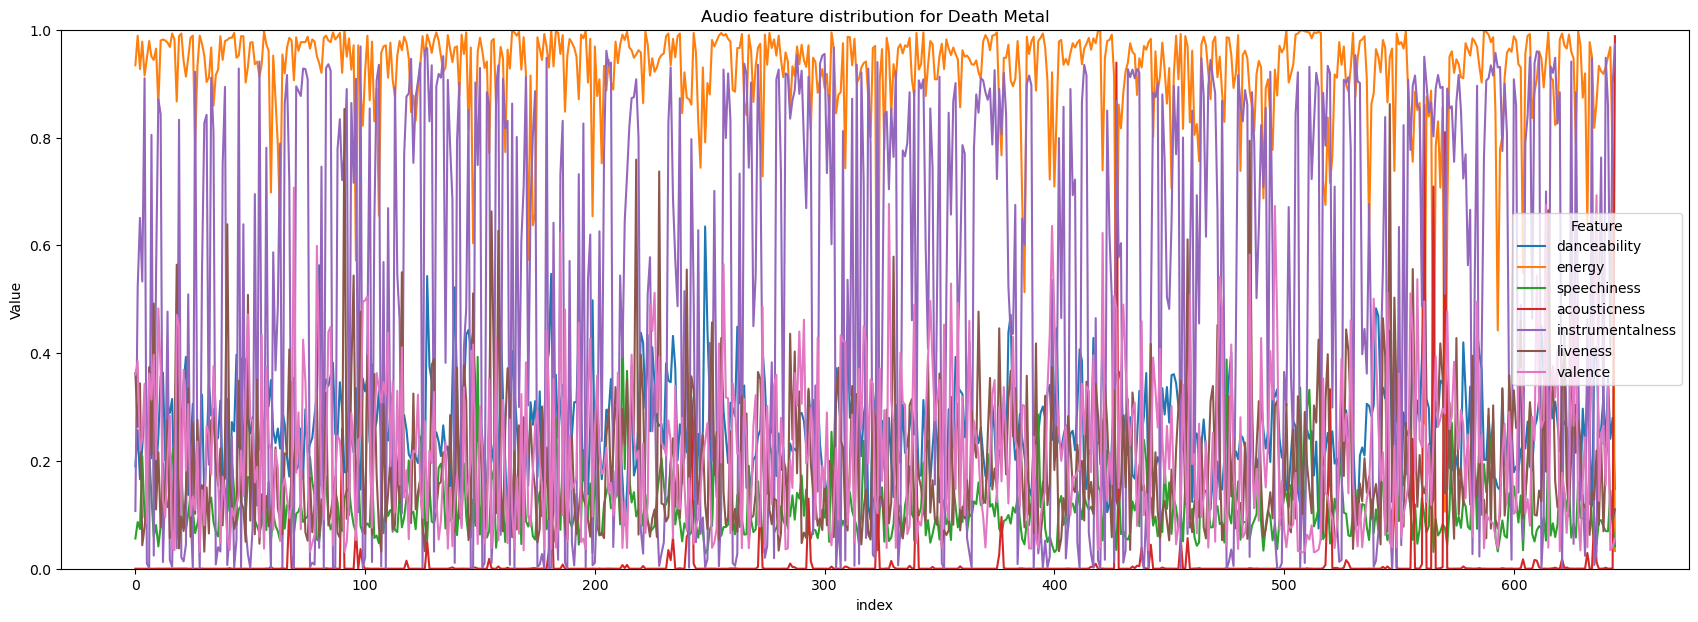

In [2875]:
# Get data
df = songs2_genres_filtered.drop(columns=['song_name','cluster','duration_ms','mode','key','time_signature','loudness','tempo','artist','id','html','cluster_genres'])

# Select which genre to plot
select_genre = 'Death Metal'

# --- PREP DATA FOR PLOTTING
df2 = (
    # Only take data for selected genre
    df[df['artist_genre']==select_genre]
    # Drop the genre-column
    .drop(columns='artist_genre')
    # Drop these columns just for readability of the plot
    .drop(columns=['speechiness','liveness','danceability'])
    # Reset index so there are no gaps between index values
    .reset_index(drop=True)
    # Do another reset_index to extract an index-column for melting
    .reset_index()
    # Make a "long DF"
    .melt(id_vars='index',var_name='Feature',value_name='Value')
)

# --- PLOTTING
plt.figure(figsize=(21,7))
ax = sns.lineplot(
    data = df2,
    x = 'index',
    y = 'Value',
    hue = 'Feature',
)
ax.set_ylim([0,1])
ax.set_title(f'Audio feature distribution for {select_genre}')

### Plot bar acoustic features for topgenres

Plot acoustic features for top 10 genres to investigate how they change depended on the music-style.

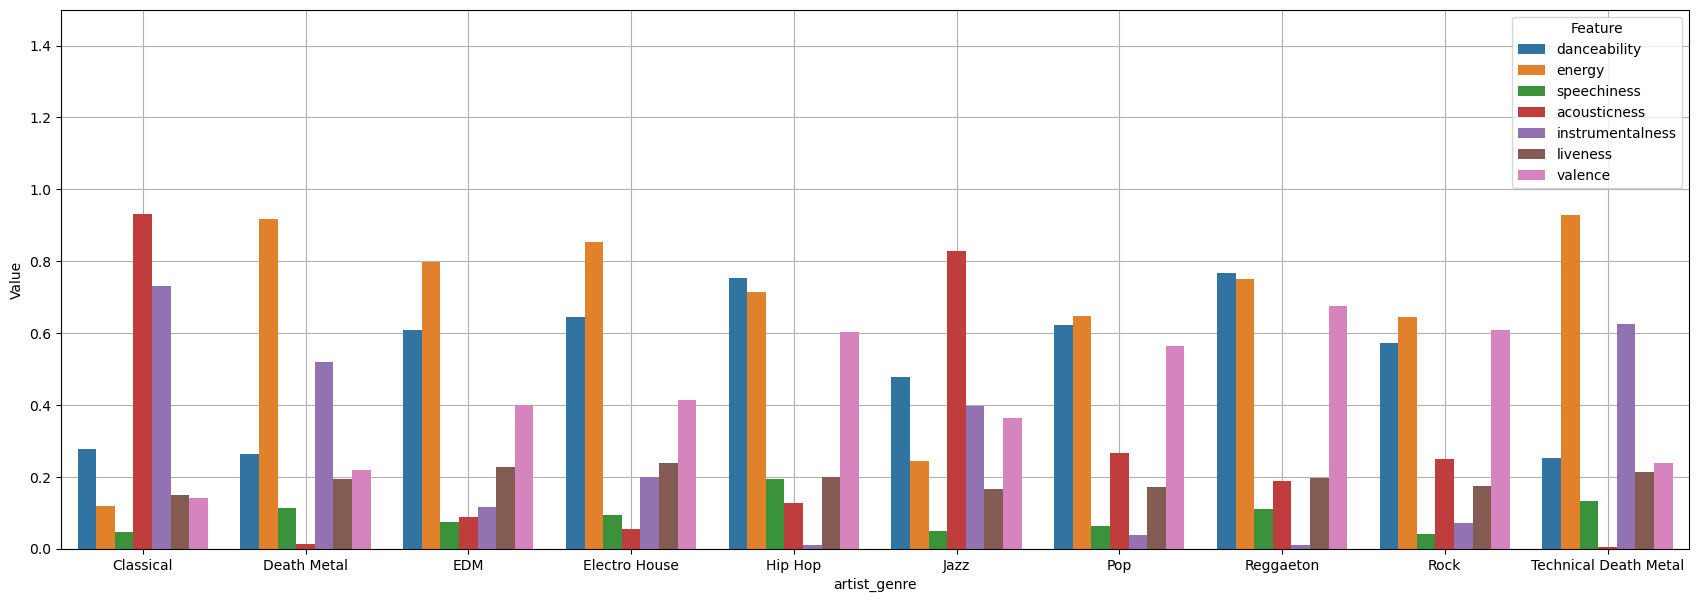

In [2873]:
# Get data
df = songs2_genres_filtered.drop(columns=['song_name','cluster','duration_ms','mode','key','time_signature','loudness','tempo','artist','id','html','cluster_genres'])

# Get value counts from artist_genre and only keep top 10
topgenres = list(df['artist_genre'].value_counts()[:10].index)

# --- PREP DF FOR PLOTTING
df2 = (
    # Only get data from top 10 genres
    df[df['artist_genre'].isin(topgenres)]
    # Group songs by genre
    .groupby('artist_genre')
    # Get average values of audio features
    .mean()
    # Extract index for melt
    .reset_index()
    # Make "long" DF
    .melt(id_vars='artist_genre',var_name='Feature',value_name='Value')
)

# --- PLOTTING
plt.figure(figsize=(21,7))
ax = sns.barplot(
    data = df2,
    y = 'Value',
    hue = 'Feature',
    x = 'artist_genre',
)
ax.set_ylim([0,1.5])
plt.grid()
ax.set_axisbelow(True)


## Quality Analysis

### QA results by manually sampling clusters

Just take a manual look at the clustered and see how the "artist_genre" is assigned.<br>
Ideally it should be mostly the same genres per cluster.

In [2871]:
# Get random sample from a specific cluster (e.g. 6)
df = songs2_genres_filtered[songs2_genres_filtered['cluster']==6][['song_name','artist','cluster','artist_genre']].sample(20,random_state=23456)

# Write to disk for further use in visualization
# df.to_csv('test.csv',index=False)

df

,song_name,artist,cluster,artist_genre
4320,Pulsating Protoplasma,Pungent Stench,6,Death Metal
4347,Putrid Intercourse,Convulse,6,Death Metal
4182,From the Dead to the Living,Fleshcrawl,6,Death Metal
3907,Ceased By Failure,Rottrevore,6,Black Metal
3601,Blood of Lions,Krisiun,6,Death Metal
3997,Mangled Dehumanization - Original Un-Triggered Mix,Master,6,Death Metal
4073,Mental Misery,Gorefest,6,Death Metal
373,Gone,Big Surr,6,Indie Pop
4021,Forged in Fire (Formed in Flame),Exhumed,6,Death Metal
3708,Phrenetic Tendencies,Fleshcrawl,6,Death Metal


### QA results by getting main artist-genres per cluster and compare with cluster-genres

Look at all the different genres per individual cluster and look at their count.<br>
Then take the top 5 genres per cluster and divide their count-sum by the overall count of songs in that cluster.<br>
The result is the percentage of top 5 genres for that cluster.<br>
Meaning that if the percentage is high, the cluster is mainly made of those top-genres.<br>
It's basically another way of describing the genre-variance per cluster (although in this case high values indicate a *low* variance).

In [1517]:
# Get data
df = songs2_genres_filtered[['song_name','artist','artist_genre','cluster_genres','cluster']]

# Initialize dict for quality assessement
qa = {'cluster':[],'cluster_genres':[],'main_genres':[],'percentage':[]}

# GO THROUGH DATA BY CLUSTER
for i in range(df['cluster'].max()+1):
    # Get counts per genre for current cluster
    df2 = df[df['cluster']==i]['artist_genre'].value_counts()
    # Store top five genres
    vc = df2[0:5]
    # Append cluster and genre information to qa-dictionary
    qa['cluster'].append(i)
    qa['cluster_genres'].append(list(df[df['cluster']==i]['cluster_genres'])[0])
    qa['main_genres'].append(str(list(vc.index)).replace("'",""))
    qa['percentage'].append(vc.values.sum()/df2.values.sum())

# Make QA dataframe and sort by percentage
qa_df = pd.DataFrame(qa).sort_values('percentage',ascending=False)

qa_df

,cluster,cluster_genres,main_genres,percentage
6,6,## Top 5 Genres:\n\n1. **Metal**\n2. **Death Metal**\n3. **Black Metal**\n4. **Grindcore**\n5. **Doom Metal**,"[Death Metal, Technical Death Metal, Grindcore, Black Metal, Melodic Death Metal]",0.851675
21,21,## Top 5 Genres:\n\n1. **Metal**\n2. **Electronic**\n3. **Rock**\n4. **Hip-hop**\n5. **Death Metal**,"[Death Metal, Black Metal, Technical Death Metal, Melodic Death Metal, Grindcore]",0.818182
1,1,## Top 5 Genres:\n\n1. **Metal**\n2. **Electronic**\n3. **Grindcore**\n4. **Doom Metal**\n5. **Death Metal**,"[Death Metal, Technical Death Metal, Black Metal, Grindcore, Melodic Death Metal]",0.818182
17,17,## Top 5 Genres:\n\n1. **Metal**\n2. **Electronic**\n3. **Death Metal**\n4. **Black Metal**\n5. **Grindcore**,"[Death Metal, Grindcore, Technical Death Metal, Black Metal, Melodic Death Metal]",0.817647
20,20,## Top 5 Genres:\n\n1. **Rock**\n2. **Indie**\n3. **Metal**\n4. **Electronic**\n5. **Death Metal**,"[Death Metal, Black Metal, Technical Death Metal, Grindcore, Melodic Death Metal]",0.776923
10,10,## Top 5 Genres:\n\n1. **Metal**\n2. **Electronic**\n3. **Hip-Hop**\n4. **Death Metal**\n5. **Black Metal**,"[Death Metal, Technical Death Metal, Black Metal, Melodic Death Metal, Gospel]",0.774648
2,2,## Top 5 Genres:\n\n1. **Classical**\n2. **Ambient**\n3. **Drone**\n4. **Minimalism**\n5. **Experimental**,"[Classical, Ambient, Electronic, Baroque, Jazz]",0.733871
3,3,## Top 5 Genres:\n\n1. **Classical**\n2. **Jazz**\n3. **Ambient**\n4. **Minimalism**\n5. **Chillout**,"[Classical, Jazz, Electronic, Baroque, Hard Bop]",0.704819
9,9,## Top 5 Genres:\n\n1. **Classical**\n2. **Ambient**\n3. **Jazz**\n4. **Piano**\n5. **Minimalism**,"[Classical, Jazz, Electronic, Hip-hop, Ambient]",0.691244
15,15,## Top 5 Genres:\n\n1. **Hip-Hop**\n2. **Pop**\n3. **Electronic**\n4. **Latin**\n5. **Brazilian**,"[Hip Hop, Pop, Reggaeton, R&B, Reggae]",0.688119


### QA - Standard Deviation of genre counts

Instead of the above mentioned method, just look directly at the standard deviation of genre counts per cluster.<br>
Note: A low standard deviation per cluster could still mean a lot of different genres per cluster. It would just mean, that those different genres are distributed evenly among the cluster.

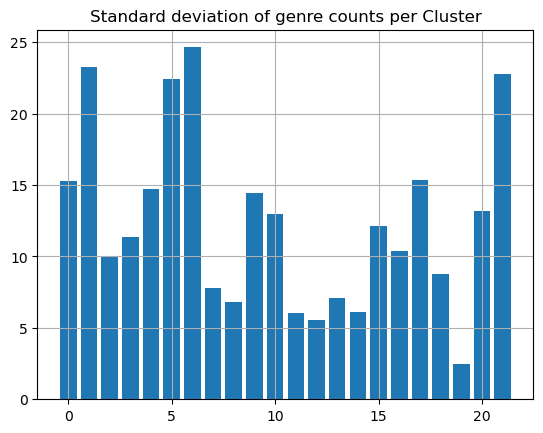

In [1535]:
# --- GET SONGS, GROUP BY CLUSTER & GET GENRE-COUNTs PER CLUSTER
df = (songs2_genres_filtered
      [['song_name','artist','artist_genre','cluster_genres','cluster']]
      .groupby(['cluster','artist_genre'],as_index=False)
      .count()
      .sort_values(['cluster','artist'],ascending=False)
      .rename(columns={'song_name':'count'})
      .drop(columns=['artist','cluster_genres'])
     )

# Pivot df and get standard deviation for plotting
df2 = df.pivot(columns='cluster',values='count').std()

# --- MAKE BAR CHART
plt.bar(df2.index,df2.values)
plt.title('Standard deviation of genre counts per Cluster')
plt.grid()